In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease 
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2972 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2496 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.2 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1299 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2069 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [55.2 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [28.6 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1000 kB]
Get:13 http://security.ub

Setting up libsndfile1:amd64 (1.0.28-7ubuntu0.1) ...
Setting up libxml2:amd64 (2.9.10+dfsg-5ubuntu0.20.04.5) ...
Setting up libvorbis-dev:amd64 (1.3.6-2ubuntu1) ...
Setting up libsndfile1-dev (1.0.28-7ubuntu0.1) ...
Setting up shared-mime-info (1.15-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     |████████████████████████████████| 34.5 MB 16.8 MB/s eta 0:00:01     |██████████████████████▎         | 24.0 MB 17.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.8 MB 9.9 MB/s eta 0:00:01     |█████████████████████▉          | 6.7 MB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 252 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 8.4 MB/s eta 0:00:01
     |████████████

In [24]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, clip_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

loading ../data/arrays/c81920_f32_clips.npy ...
The clip array has 14260 clips.


In [25]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

creating ../data/arrays/c81920_f32_clips_w10240_h640_cqts.npy ...
cqt progress: clip 1 / 14260
cqt progress: clip 2 / 14260
cqt progress: clip 3 / 14260
cqt progress: clip 4 / 14260
cqt progress: clip 5 / 14260
cqt progress: clip 6 / 14260
cqt progress: clip 7 / 14260
cqt progress: clip 8 / 14260
cqt progress: clip 9 / 14260
cqt progress: clip 10 / 14260
cqt progress: clip 11 / 14260
cqt progress: clip 12 / 14260
cqt progress: clip 13 / 14260
cqt progress: clip 14 / 14260
cqt progress: clip 15 / 14260
cqt progress: clip 16 / 14260
cqt progress: clip 17 / 14260
cqt progress: clip 18 / 14260
cqt progress: clip 19 / 14260
cqt progress: clip 20 / 14260
cqt progress: clip 21 / 14260
cqt progress: clip 22 / 14260
cqt progress: clip 23 / 14260
cqt progress: clip 24 / 14260
cqt progress: clip 25 / 14260
cqt progress: clip 26 / 14260
cqt progress: clip 27 / 14260
cqt progress: clip 28 / 14260
cqt progress: clip 29 / 14260
cqt progress: clip 30 / 14260
cqt progress: clip 31 / 14260
cqt progress:

cqt progress: clip 271 / 14260
cqt progress: clip 272 / 14260
cqt progress: clip 273 / 14260
cqt progress: clip 274 / 14260
cqt progress: clip 275 / 14260
cqt progress: clip 276 / 14260
cqt progress: clip 277 / 14260
cqt progress: clip 278 / 14260
cqt progress: clip 279 / 14260
cqt progress: clip 280 / 14260
cqt progress: clip 281 / 14260
cqt progress: clip 282 / 14260
cqt progress: clip 283 / 14260
cqt progress: clip 284 / 14260
cqt progress: clip 285 / 14260
cqt progress: clip 286 / 14260
cqt progress: clip 287 / 14260
cqt progress: clip 288 / 14260
cqt progress: clip 289 / 14260
cqt progress: clip 290 / 14260
cqt progress: clip 291 / 14260
cqt progress: clip 292 / 14260
cqt progress: clip 293 / 14260
cqt progress: clip 294 / 14260
cqt progress: clip 295 / 14260
cqt progress: clip 296 / 14260
cqt progress: clip 297 / 14260
cqt progress: clip 298 / 14260
cqt progress: clip 299 / 14260
cqt progress: clip 300 / 14260
cqt progress: clip 301 / 14260
cqt progress: clip 302 / 14260
cqt prog

cqt progress: clip 536 / 14260
cqt progress: clip 537 / 14260
cqt progress: clip 538 / 14260
cqt progress: clip 539 / 14260
cqt progress: clip 540 / 14260
cqt progress: clip 541 / 14260
cqt progress: clip 542 / 14260
cqt progress: clip 543 / 14260
cqt progress: clip 544 / 14260
cqt progress: clip 545 / 14260
cqt progress: clip 546 / 14260
cqt progress: clip 547 / 14260
cqt progress: clip 548 / 14260
cqt progress: clip 549 / 14260
cqt progress: clip 550 / 14260
cqt progress: clip 551 / 14260
cqt progress: clip 552 / 14260
cqt progress: clip 553 / 14260
cqt progress: clip 554 / 14260
cqt progress: clip 555 / 14260
cqt progress: clip 556 / 14260
cqt progress: clip 557 / 14260
cqt progress: clip 558 / 14260
cqt progress: clip 559 / 14260
cqt progress: clip 560 / 14260
cqt progress: clip 561 / 14260
cqt progress: clip 562 / 14260
cqt progress: clip 563 / 14260
cqt progress: clip 564 / 14260
cqt progress: clip 565 / 14260
cqt progress: clip 566 / 14260
cqt progress: clip 567 / 14260
cqt prog

cqt progress: clip 805 / 14260
cqt progress: clip 806 / 14260
cqt progress: clip 807 / 14260
cqt progress: clip 808 / 14260
cqt progress: clip 809 / 14260
cqt progress: clip 810 / 14260
cqt progress: clip 811 / 14260
cqt progress: clip 812 / 14260
cqt progress: clip 813 / 14260
cqt progress: clip 814 / 14260
cqt progress: clip 815 / 14260
cqt progress: clip 816 / 14260
cqt progress: clip 817 / 14260
cqt progress: clip 818 / 14260
cqt progress: clip 819 / 14260
cqt progress: clip 820 / 14260
cqt progress: clip 821 / 14260
cqt progress: clip 822 / 14260
cqt progress: clip 823 / 14260
cqt progress: clip 824 / 14260
cqt progress: clip 825 / 14260
cqt progress: clip 826 / 14260
cqt progress: clip 827 / 14260
cqt progress: clip 828 / 14260
cqt progress: clip 829 / 14260
cqt progress: clip 830 / 14260
cqt progress: clip 831 / 14260
cqt progress: clip 832 / 14260
cqt progress: clip 833 / 14260
cqt progress: clip 834 / 14260
cqt progress: clip 835 / 14260
cqt progress: clip 836 / 14260
cqt prog

cqt progress: clip 1069 / 14260
cqt progress: clip 1070 / 14260
cqt progress: clip 1071 / 14260
cqt progress: clip 1072 / 14260
cqt progress: clip 1073 / 14260
cqt progress: clip 1074 / 14260
cqt progress: clip 1075 / 14260
cqt progress: clip 1076 / 14260
cqt progress: clip 1077 / 14260
cqt progress: clip 1078 / 14260
cqt progress: clip 1079 / 14260
cqt progress: clip 1080 / 14260
cqt progress: clip 1081 / 14260
cqt progress: clip 1082 / 14260
cqt progress: clip 1083 / 14260
cqt progress: clip 1084 / 14260
cqt progress: clip 1085 / 14260
cqt progress: clip 1086 / 14260
cqt progress: clip 1087 / 14260
cqt progress: clip 1088 / 14260
cqt progress: clip 1089 / 14260
cqt progress: clip 1090 / 14260
cqt progress: clip 1091 / 14260
cqt progress: clip 1092 / 14260
cqt progress: clip 1093 / 14260
cqt progress: clip 1094 / 14260
cqt progress: clip 1095 / 14260
cqt progress: clip 1096 / 14260
cqt progress: clip 1097 / 14260
cqt progress: clip 1098 / 14260
cqt progress: clip 1099 / 14260
cqt prog

cqt progress: clip 1329 / 14260
cqt progress: clip 1330 / 14260
cqt progress: clip 1331 / 14260
cqt progress: clip 1332 / 14260
cqt progress: clip 1333 / 14260
cqt progress: clip 1334 / 14260
cqt progress: clip 1335 / 14260
cqt progress: clip 1336 / 14260
cqt progress: clip 1337 / 14260
cqt progress: clip 1338 / 14260
cqt progress: clip 1339 / 14260
cqt progress: clip 1340 / 14260
cqt progress: clip 1341 / 14260
cqt progress: clip 1342 / 14260
cqt progress: clip 1343 / 14260
cqt progress: clip 1344 / 14260
cqt progress: clip 1345 / 14260
cqt progress: clip 1346 / 14260
cqt progress: clip 1347 / 14260
cqt progress: clip 1348 / 14260
cqt progress: clip 1349 / 14260
cqt progress: clip 1350 / 14260
cqt progress: clip 1351 / 14260
cqt progress: clip 1352 / 14260
cqt progress: clip 1353 / 14260
cqt progress: clip 1354 / 14260
cqt progress: clip 1355 / 14260
cqt progress: clip 1356 / 14260
cqt progress: clip 1357 / 14260
cqt progress: clip 1358 / 14260
cqt progress: clip 1359 / 14260
cqt prog

cqt progress: clip 1586 / 14260
cqt progress: clip 1587 / 14260
cqt progress: clip 1588 / 14260
cqt progress: clip 1589 / 14260
cqt progress: clip 1590 / 14260
cqt progress: clip 1591 / 14260
cqt progress: clip 1592 / 14260
cqt progress: clip 1593 / 14260
cqt progress: clip 1594 / 14260
cqt progress: clip 1595 / 14260
cqt progress: clip 1596 / 14260
cqt progress: clip 1597 / 14260
cqt progress: clip 1598 / 14260
cqt progress: clip 1599 / 14260
cqt progress: clip 1600 / 14260
cqt progress: clip 1601 / 14260
cqt progress: clip 1602 / 14260
cqt progress: clip 1603 / 14260
cqt progress: clip 1604 / 14260
cqt progress: clip 1605 / 14260
cqt progress: clip 1606 / 14260
cqt progress: clip 1607 / 14260
cqt progress: clip 1608 / 14260
cqt progress: clip 1609 / 14260
cqt progress: clip 1610 / 14260
cqt progress: clip 1611 / 14260
cqt progress: clip 1612 / 14260
cqt progress: clip 1613 / 14260
cqt progress: clip 1614 / 14260
cqt progress: clip 1615 / 14260
cqt progress: clip 1616 / 14260
cqt prog

cqt progress: clip 1846 / 14260
cqt progress: clip 1847 / 14260
cqt progress: clip 1848 / 14260
cqt progress: clip 1849 / 14260
cqt progress: clip 1850 / 14260
cqt progress: clip 1851 / 14260
cqt progress: clip 1852 / 14260
cqt progress: clip 1853 / 14260
cqt progress: clip 1854 / 14260
cqt progress: clip 1855 / 14260
cqt progress: clip 1856 / 14260
cqt progress: clip 1857 / 14260
cqt progress: clip 1858 / 14260
cqt progress: clip 1859 / 14260
cqt progress: clip 1860 / 14260
cqt progress: clip 1861 / 14260
cqt progress: clip 1862 / 14260
cqt progress: clip 1863 / 14260
cqt progress: clip 1864 / 14260
cqt progress: clip 1865 / 14260
cqt progress: clip 1866 / 14260
cqt progress: clip 1867 / 14260
cqt progress: clip 1868 / 14260
cqt progress: clip 1869 / 14260
cqt progress: clip 1870 / 14260
cqt progress: clip 1871 / 14260
cqt progress: clip 1872 / 14260
cqt progress: clip 1873 / 14260
cqt progress: clip 1874 / 14260
cqt progress: clip 1875 / 14260
cqt progress: clip 1876 / 14260
cqt prog

cqt progress: clip 2106 / 14260
cqt progress: clip 2107 / 14260
cqt progress: clip 2108 / 14260
cqt progress: clip 2109 / 14260
cqt progress: clip 2110 / 14260
cqt progress: clip 2111 / 14260
cqt progress: clip 2112 / 14260
cqt progress: clip 2113 / 14260
cqt progress: clip 2114 / 14260
cqt progress: clip 2115 / 14260
cqt progress: clip 2116 / 14260
cqt progress: clip 2117 / 14260
cqt progress: clip 2118 / 14260
cqt progress: clip 2119 / 14260
cqt progress: clip 2120 / 14260
cqt progress: clip 2121 / 14260
cqt progress: clip 2122 / 14260
cqt progress: clip 2123 / 14260
cqt progress: clip 2124 / 14260
cqt progress: clip 2125 / 14260
cqt progress: clip 2126 / 14260
cqt progress: clip 2127 / 14260
cqt progress: clip 2128 / 14260
cqt progress: clip 2129 / 14260
cqt progress: clip 2130 / 14260
cqt progress: clip 2131 / 14260
cqt progress: clip 2132 / 14260
cqt progress: clip 2133 / 14260
cqt progress: clip 2134 / 14260
cqt progress: clip 2135 / 14260
cqt progress: clip 2136 / 14260
cqt prog

cqt progress: clip 2366 / 14260
cqt progress: clip 2367 / 14260
cqt progress: clip 2368 / 14260
cqt progress: clip 2369 / 14260
cqt progress: clip 2370 / 14260
cqt progress: clip 2371 / 14260
cqt progress: clip 2372 / 14260
cqt progress: clip 2373 / 14260
cqt progress: clip 2374 / 14260
cqt progress: clip 2375 / 14260
cqt progress: clip 2376 / 14260
cqt progress: clip 2377 / 14260
cqt progress: clip 2378 / 14260
cqt progress: clip 2379 / 14260
cqt progress: clip 2380 / 14260
cqt progress: clip 2381 / 14260
cqt progress: clip 2382 / 14260
cqt progress: clip 2383 / 14260
cqt progress: clip 2384 / 14260
cqt progress: clip 2385 / 14260
cqt progress: clip 2386 / 14260
cqt progress: clip 2387 / 14260
cqt progress: clip 2388 / 14260
cqt progress: clip 2389 / 14260
cqt progress: clip 2390 / 14260
cqt progress: clip 2391 / 14260
cqt progress: clip 2392 / 14260
cqt progress: clip 2393 / 14260
cqt progress: clip 2394 / 14260
cqt progress: clip 2395 / 14260
cqt progress: clip 2396 / 14260
cqt prog

cqt progress: clip 2624 / 14260
cqt progress: clip 2625 / 14260
cqt progress: clip 2626 / 14260
cqt progress: clip 2627 / 14260
cqt progress: clip 2628 / 14260
cqt progress: clip 2629 / 14260
cqt progress: clip 2630 / 14260
cqt progress: clip 2631 / 14260
cqt progress: clip 2632 / 14260
cqt progress: clip 2633 / 14260
cqt progress: clip 2634 / 14260
cqt progress: clip 2635 / 14260
cqt progress: clip 2636 / 14260
cqt progress: clip 2637 / 14260
cqt progress: clip 2638 / 14260
cqt progress: clip 2639 / 14260
cqt progress: clip 2640 / 14260
cqt progress: clip 2641 / 14260
cqt progress: clip 2642 / 14260
cqt progress: clip 2643 / 14260
cqt progress: clip 2644 / 14260
cqt progress: clip 2645 / 14260
cqt progress: clip 2646 / 14260
cqt progress: clip 2647 / 14260
cqt progress: clip 2648 / 14260
cqt progress: clip 2649 / 14260
cqt progress: clip 2650 / 14260
cqt progress: clip 2651 / 14260
cqt progress: clip 2652 / 14260
cqt progress: clip 2653 / 14260
cqt progress: clip 2654 / 14260
cqt prog

cqt progress: clip 2881 / 14260
cqt progress: clip 2882 / 14260
cqt progress: clip 2883 / 14260
cqt progress: clip 2884 / 14260
cqt progress: clip 2885 / 14260
cqt progress: clip 2886 / 14260
cqt progress: clip 2887 / 14260
cqt progress: clip 2888 / 14260
cqt progress: clip 2889 / 14260
cqt progress: clip 2890 / 14260
cqt progress: clip 2891 / 14260
cqt progress: clip 2892 / 14260
cqt progress: clip 2893 / 14260
cqt progress: clip 2894 / 14260
cqt progress: clip 2895 / 14260
cqt progress: clip 2896 / 14260
cqt progress: clip 2897 / 14260
cqt progress: clip 2898 / 14260
cqt progress: clip 2899 / 14260
cqt progress: clip 2900 / 14260
cqt progress: clip 2901 / 14260
cqt progress: clip 2902 / 14260
cqt progress: clip 2903 / 14260
cqt progress: clip 2904 / 14260
cqt progress: clip 2905 / 14260
cqt progress: clip 2906 / 14260
cqt progress: clip 2907 / 14260
cqt progress: clip 2908 / 14260
cqt progress: clip 2909 / 14260
cqt progress: clip 2910 / 14260
cqt progress: clip 2911 / 14260
cqt prog

cqt progress: clip 3140 / 14260
cqt progress: clip 3141 / 14260
cqt progress: clip 3142 / 14260
cqt progress: clip 3143 / 14260
cqt progress: clip 3144 / 14260
cqt progress: clip 3145 / 14260
cqt progress: clip 3146 / 14260
cqt progress: clip 3147 / 14260
cqt progress: clip 3148 / 14260
cqt progress: clip 3149 / 14260
cqt progress: clip 3150 / 14260
cqt progress: clip 3151 / 14260
cqt progress: clip 3152 / 14260
cqt progress: clip 3153 / 14260
cqt progress: clip 3154 / 14260
cqt progress: clip 3155 / 14260
cqt progress: clip 3156 / 14260
cqt progress: clip 3157 / 14260
cqt progress: clip 3158 / 14260
cqt progress: clip 3159 / 14260
cqt progress: clip 3160 / 14260
cqt progress: clip 3161 / 14260
cqt progress: clip 3162 / 14260
cqt progress: clip 3163 / 14260
cqt progress: clip 3164 / 14260
cqt progress: clip 3165 / 14260
cqt progress: clip 3166 / 14260
cqt progress: clip 3167 / 14260
cqt progress: clip 3168 / 14260
cqt progress: clip 3169 / 14260
cqt progress: clip 3170 / 14260
cqt prog

cqt progress: clip 3399 / 14260
cqt progress: clip 3400 / 14260
cqt progress: clip 3401 / 14260
cqt progress: clip 3402 / 14260
cqt progress: clip 3403 / 14260
cqt progress: clip 3404 / 14260
cqt progress: clip 3405 / 14260
cqt progress: clip 3406 / 14260
cqt progress: clip 3407 / 14260
cqt progress: clip 3408 / 14260
cqt progress: clip 3409 / 14260
cqt progress: clip 3410 / 14260
cqt progress: clip 3411 / 14260
cqt progress: clip 3412 / 14260
cqt progress: clip 3413 / 14260
cqt progress: clip 3414 / 14260
cqt progress: clip 3415 / 14260
cqt progress: clip 3416 / 14260
cqt progress: clip 3417 / 14260
cqt progress: clip 3418 / 14260
cqt progress: clip 3419 / 14260
cqt progress: clip 3420 / 14260
cqt progress: clip 3421 / 14260
cqt progress: clip 3422 / 14260
cqt progress: clip 3423 / 14260
cqt progress: clip 3424 / 14260
cqt progress: clip 3425 / 14260
cqt progress: clip 3426 / 14260
cqt progress: clip 3427 / 14260
cqt progress: clip 3428 / 14260
cqt progress: clip 3429 / 14260
cqt prog

cqt progress: clip 3657 / 14260
cqt progress: clip 3658 / 14260
cqt progress: clip 3659 / 14260
cqt progress: clip 3660 / 14260
cqt progress: clip 3661 / 14260
cqt progress: clip 3662 / 14260
cqt progress: clip 3663 / 14260
cqt progress: clip 3664 / 14260
cqt progress: clip 3665 / 14260
cqt progress: clip 3666 / 14260
cqt progress: clip 3667 / 14260
cqt progress: clip 3668 / 14260
cqt progress: clip 3669 / 14260
cqt progress: clip 3670 / 14260
cqt progress: clip 3671 / 14260
cqt progress: clip 3672 / 14260
cqt progress: clip 3673 / 14260
cqt progress: clip 3674 / 14260
cqt progress: clip 3675 / 14260
cqt progress: clip 3676 / 14260
cqt progress: clip 3677 / 14260
cqt progress: clip 3678 / 14260
cqt progress: clip 3679 / 14260
cqt progress: clip 3680 / 14260
cqt progress: clip 3681 / 14260
cqt progress: clip 3682 / 14260
cqt progress: clip 3683 / 14260
cqt progress: clip 3684 / 14260
cqt progress: clip 3685 / 14260
cqt progress: clip 3686 / 14260
cqt progress: clip 3687 / 14260
cqt prog

cqt progress: clip 3915 / 14260
cqt progress: clip 3916 / 14260
cqt progress: clip 3917 / 14260
cqt progress: clip 3918 / 14260
cqt progress: clip 3919 / 14260
cqt progress: clip 3920 / 14260
cqt progress: clip 3921 / 14260
cqt progress: clip 3922 / 14260
cqt progress: clip 3923 / 14260
cqt progress: clip 3924 / 14260
cqt progress: clip 3925 / 14260
cqt progress: clip 3926 / 14260
cqt progress: clip 3927 / 14260
cqt progress: clip 3928 / 14260
cqt progress: clip 3929 / 14260
cqt progress: clip 3930 / 14260
cqt progress: clip 3931 / 14260
cqt progress: clip 3932 / 14260
cqt progress: clip 3933 / 14260
cqt progress: clip 3934 / 14260
cqt progress: clip 3935 / 14260
cqt progress: clip 3936 / 14260
cqt progress: clip 3937 / 14260
cqt progress: clip 3938 / 14260
cqt progress: clip 3939 / 14260
cqt progress: clip 3940 / 14260
cqt progress: clip 3941 / 14260
cqt progress: clip 3942 / 14260
cqt progress: clip 3943 / 14260
cqt progress: clip 3944 / 14260
cqt progress: clip 3945 / 14260
cqt prog

cqt progress: clip 4173 / 14260
cqt progress: clip 4174 / 14260
cqt progress: clip 4175 / 14260
cqt progress: clip 4176 / 14260
cqt progress: clip 4177 / 14260
cqt progress: clip 4178 / 14260
cqt progress: clip 4179 / 14260
cqt progress: clip 4180 / 14260
cqt progress: clip 4181 / 14260
cqt progress: clip 4182 / 14260
cqt progress: clip 4183 / 14260
cqt progress: clip 4184 / 14260
cqt progress: clip 4185 / 14260
cqt progress: clip 4186 / 14260
cqt progress: clip 4187 / 14260
cqt progress: clip 4188 / 14260
cqt progress: clip 4189 / 14260
cqt progress: clip 4190 / 14260
cqt progress: clip 4191 / 14260
cqt progress: clip 4192 / 14260
cqt progress: clip 4193 / 14260
cqt progress: clip 4194 / 14260
cqt progress: clip 4195 / 14260
cqt progress: clip 4196 / 14260
cqt progress: clip 4197 / 14260
cqt progress: clip 4198 / 14260
cqt progress: clip 4199 / 14260
cqt progress: clip 4200 / 14260
cqt progress: clip 4201 / 14260
cqt progress: clip 4202 / 14260
cqt progress: clip 4203 / 14260
cqt prog

cqt progress: clip 4431 / 14260
cqt progress: clip 4432 / 14260
cqt progress: clip 4433 / 14260
cqt progress: clip 4434 / 14260
cqt progress: clip 4435 / 14260
cqt progress: clip 4436 / 14260
cqt progress: clip 4437 / 14260
cqt progress: clip 4438 / 14260
cqt progress: clip 4439 / 14260
cqt progress: clip 4440 / 14260
cqt progress: clip 4441 / 14260
cqt progress: clip 4442 / 14260
cqt progress: clip 4443 / 14260
cqt progress: clip 4444 / 14260
cqt progress: clip 4445 / 14260
cqt progress: clip 4446 / 14260
cqt progress: clip 4447 / 14260
cqt progress: clip 4448 / 14260
cqt progress: clip 4449 / 14260
cqt progress: clip 4450 / 14260
cqt progress: clip 4451 / 14260
cqt progress: clip 4452 / 14260
cqt progress: clip 4453 / 14260
cqt progress: clip 4454 / 14260
cqt progress: clip 4455 / 14260
cqt progress: clip 4456 / 14260
cqt progress: clip 4457 / 14260
cqt progress: clip 4458 / 14260
cqt progress: clip 4459 / 14260
cqt progress: clip 4460 / 14260
cqt progress: clip 4461 / 14260
cqt prog

cqt progress: clip 4689 / 14260
cqt progress: clip 4690 / 14260
cqt progress: clip 4691 / 14260
cqt progress: clip 4692 / 14260
cqt progress: clip 4693 / 14260
cqt progress: clip 4694 / 14260
cqt progress: clip 4695 / 14260
cqt progress: clip 4696 / 14260
cqt progress: clip 4697 / 14260
cqt progress: clip 4698 / 14260
cqt progress: clip 4699 / 14260
cqt progress: clip 4700 / 14260
cqt progress: clip 4701 / 14260
cqt progress: clip 4702 / 14260
cqt progress: clip 4703 / 14260
cqt progress: clip 4704 / 14260
cqt progress: clip 4705 / 14260
cqt progress: clip 4706 / 14260
cqt progress: clip 4707 / 14260
cqt progress: clip 4708 / 14260
cqt progress: clip 4709 / 14260
cqt progress: clip 4710 / 14260
cqt progress: clip 4711 / 14260
cqt progress: clip 4712 / 14260
cqt progress: clip 4713 / 14260
cqt progress: clip 4714 / 14260
cqt progress: clip 4715 / 14260
cqt progress: clip 4716 / 14260
cqt progress: clip 4717 / 14260
cqt progress: clip 4718 / 14260
cqt progress: clip 4719 / 14260
cqt prog

cqt progress: clip 4946 / 14260
cqt progress: clip 4947 / 14260
cqt progress: clip 4948 / 14260
cqt progress: clip 4949 / 14260
cqt progress: clip 4950 / 14260
cqt progress: clip 4951 / 14260
cqt progress: clip 4952 / 14260
cqt progress: clip 4953 / 14260
cqt progress: clip 4954 / 14260
cqt progress: clip 4955 / 14260
cqt progress: clip 4956 / 14260
cqt progress: clip 4957 / 14260
cqt progress: clip 4958 / 14260
cqt progress: clip 4959 / 14260
cqt progress: clip 4960 / 14260
cqt progress: clip 4961 / 14260
cqt progress: clip 4962 / 14260
cqt progress: clip 4963 / 14260
cqt progress: clip 4964 / 14260
cqt progress: clip 4965 / 14260
cqt progress: clip 4966 / 14260
cqt progress: clip 4967 / 14260
cqt progress: clip 4968 / 14260
cqt progress: clip 4969 / 14260
cqt progress: clip 4970 / 14260
cqt progress: clip 4971 / 14260
cqt progress: clip 4972 / 14260
cqt progress: clip 4973 / 14260
cqt progress: clip 4974 / 14260
cqt progress: clip 4975 / 14260
cqt progress: clip 4976 / 14260
cqt prog

cqt progress: clip 5204 / 14260
cqt progress: clip 5205 / 14260
cqt progress: clip 5206 / 14260
cqt progress: clip 5207 / 14260
cqt progress: clip 5208 / 14260
cqt progress: clip 5209 / 14260
cqt progress: clip 5210 / 14260
cqt progress: clip 5211 / 14260
cqt progress: clip 5212 / 14260
cqt progress: clip 5213 / 14260
cqt progress: clip 5214 / 14260
cqt progress: clip 5215 / 14260
cqt progress: clip 5216 / 14260
cqt progress: clip 5217 / 14260
cqt progress: clip 5218 / 14260
cqt progress: clip 5219 / 14260
cqt progress: clip 5220 / 14260
cqt progress: clip 5221 / 14260
cqt progress: clip 5222 / 14260
cqt progress: clip 5223 / 14260
cqt progress: clip 5224 / 14260
cqt progress: clip 5225 / 14260
cqt progress: clip 5226 / 14260
cqt progress: clip 5227 / 14260
cqt progress: clip 5228 / 14260
cqt progress: clip 5229 / 14260
cqt progress: clip 5230 / 14260
cqt progress: clip 5231 / 14260
cqt progress: clip 5232 / 14260
cqt progress: clip 5233 / 14260
cqt progress: clip 5234 / 14260
cqt prog

cqt progress: clip 5463 / 14260
cqt progress: clip 5464 / 14260
cqt progress: clip 5465 / 14260
cqt progress: clip 5466 / 14260
cqt progress: clip 5467 / 14260
cqt progress: clip 5468 / 14260
cqt progress: clip 5469 / 14260
cqt progress: clip 5470 / 14260
cqt progress: clip 5471 / 14260
cqt progress: clip 5472 / 14260
cqt progress: clip 5473 / 14260
cqt progress: clip 5474 / 14260
cqt progress: clip 5475 / 14260
cqt progress: clip 5476 / 14260
cqt progress: clip 5477 / 14260
cqt progress: clip 5478 / 14260
cqt progress: clip 5479 / 14260
cqt progress: clip 5480 / 14260
cqt progress: clip 5481 / 14260
cqt progress: clip 5482 / 14260
cqt progress: clip 5483 / 14260
cqt progress: clip 5484 / 14260
cqt progress: clip 5485 / 14260
cqt progress: clip 5486 / 14260
cqt progress: clip 5487 / 14260
cqt progress: clip 5488 / 14260
cqt progress: clip 5489 / 14260
cqt progress: clip 5490 / 14260
cqt progress: clip 5491 / 14260
cqt progress: clip 5492 / 14260
cqt progress: clip 5493 / 14260
cqt prog

cqt progress: clip 5722 / 14260
cqt progress: clip 5723 / 14260
cqt progress: clip 5724 / 14260
cqt progress: clip 5725 / 14260
cqt progress: clip 5726 / 14260
cqt progress: clip 5727 / 14260
cqt progress: clip 5728 / 14260
cqt progress: clip 5729 / 14260
cqt progress: clip 5730 / 14260
cqt progress: clip 5731 / 14260
cqt progress: clip 5732 / 14260
cqt progress: clip 5733 / 14260
cqt progress: clip 5734 / 14260
cqt progress: clip 5735 / 14260
cqt progress: clip 5736 / 14260
cqt progress: clip 5737 / 14260
cqt progress: clip 5738 / 14260
cqt progress: clip 5739 / 14260
cqt progress: clip 5740 / 14260
cqt progress: clip 5741 / 14260
cqt progress: clip 5742 / 14260
cqt progress: clip 5743 / 14260
cqt progress: clip 5744 / 14260
cqt progress: clip 5745 / 14260
cqt progress: clip 5746 / 14260
cqt progress: clip 5747 / 14260
cqt progress: clip 5748 / 14260
cqt progress: clip 5749 / 14260
cqt progress: clip 5750 / 14260
cqt progress: clip 5751 / 14260
cqt progress: clip 5752 / 14260
cqt prog

cqt progress: clip 5981 / 14260
cqt progress: clip 5982 / 14260
cqt progress: clip 5983 / 14260
cqt progress: clip 5984 / 14260
cqt progress: clip 5985 / 14260
cqt progress: clip 5986 / 14260
cqt progress: clip 5987 / 14260
cqt progress: clip 5988 / 14260
cqt progress: clip 5989 / 14260
cqt progress: clip 5990 / 14260
cqt progress: clip 5991 / 14260
cqt progress: clip 5992 / 14260
cqt progress: clip 5993 / 14260
cqt progress: clip 5994 / 14260
cqt progress: clip 5995 / 14260
cqt progress: clip 5996 / 14260
cqt progress: clip 5997 / 14260
cqt progress: clip 5998 / 14260
cqt progress: clip 5999 / 14260
cqt progress: clip 6000 / 14260
cqt progress: clip 6001 / 14260
cqt progress: clip 6002 / 14260
cqt progress: clip 6003 / 14260
cqt progress: clip 6004 / 14260
cqt progress: clip 6005 / 14260
cqt progress: clip 6006 / 14260
cqt progress: clip 6007 / 14260
cqt progress: clip 6008 / 14260
cqt progress: clip 6009 / 14260
cqt progress: clip 6010 / 14260
cqt progress: clip 6011 / 14260
cqt prog

cqt progress: clip 6239 / 14260
cqt progress: clip 6240 / 14260
cqt progress: clip 6241 / 14260
cqt progress: clip 6242 / 14260
cqt progress: clip 6243 / 14260
cqt progress: clip 6244 / 14260
cqt progress: clip 6245 / 14260
cqt progress: clip 6246 / 14260
cqt progress: clip 6247 / 14260
cqt progress: clip 6248 / 14260
cqt progress: clip 6249 / 14260
cqt progress: clip 6250 / 14260
cqt progress: clip 6251 / 14260
cqt progress: clip 6252 / 14260
cqt progress: clip 6253 / 14260
cqt progress: clip 6254 / 14260
cqt progress: clip 6255 / 14260
cqt progress: clip 6256 / 14260
cqt progress: clip 6257 / 14260
cqt progress: clip 6258 / 14260
cqt progress: clip 6259 / 14260
cqt progress: clip 6260 / 14260
cqt progress: clip 6261 / 14260
cqt progress: clip 6262 / 14260
cqt progress: clip 6263 / 14260
cqt progress: clip 6264 / 14260
cqt progress: clip 6265 / 14260
cqt progress: clip 6266 / 14260
cqt progress: clip 6267 / 14260
cqt progress: clip 6268 / 14260
cqt progress: clip 6269 / 14260
cqt prog

cqt progress: clip 6499 / 14260
cqt progress: clip 6500 / 14260
cqt progress: clip 6501 / 14260
cqt progress: clip 6502 / 14260
cqt progress: clip 6503 / 14260
cqt progress: clip 6504 / 14260
cqt progress: clip 6505 / 14260
cqt progress: clip 6506 / 14260
cqt progress: clip 6507 / 14260
cqt progress: clip 6508 / 14260
cqt progress: clip 6509 / 14260
cqt progress: clip 6510 / 14260
cqt progress: clip 6511 / 14260
cqt progress: clip 6512 / 14260
cqt progress: clip 6513 / 14260
cqt progress: clip 6514 / 14260
cqt progress: clip 6515 / 14260
cqt progress: clip 6516 / 14260
cqt progress: clip 6517 / 14260
cqt progress: clip 6518 / 14260
cqt progress: clip 6519 / 14260
cqt progress: clip 6520 / 14260
cqt progress: clip 6521 / 14260
cqt progress: clip 6522 / 14260
cqt progress: clip 6523 / 14260
cqt progress: clip 6524 / 14260
cqt progress: clip 6525 / 14260
cqt progress: clip 6526 / 14260
cqt progress: clip 6527 / 14260
cqt progress: clip 6528 / 14260
cqt progress: clip 6529 / 14260
cqt prog

cqt progress: clip 6757 / 14260
cqt progress: clip 6758 / 14260
cqt progress: clip 6759 / 14260
cqt progress: clip 6760 / 14260
cqt progress: clip 6761 / 14260
cqt progress: clip 6762 / 14260
cqt progress: clip 6763 / 14260
cqt progress: clip 6764 / 14260
cqt progress: clip 6765 / 14260
cqt progress: clip 6766 / 14260
cqt progress: clip 6767 / 14260
cqt progress: clip 6768 / 14260
cqt progress: clip 6769 / 14260
cqt progress: clip 6770 / 14260
cqt progress: clip 6771 / 14260
cqt progress: clip 6772 / 14260
cqt progress: clip 6773 / 14260
cqt progress: clip 6774 / 14260
cqt progress: clip 6775 / 14260
cqt progress: clip 6776 / 14260
cqt progress: clip 6777 / 14260
cqt progress: clip 6778 / 14260
cqt progress: clip 6779 / 14260
cqt progress: clip 6780 / 14260
cqt progress: clip 6781 / 14260
cqt progress: clip 6782 / 14260
cqt progress: clip 6783 / 14260
cqt progress: clip 6784 / 14260
cqt progress: clip 6785 / 14260
cqt progress: clip 6786 / 14260
cqt progress: clip 6787 / 14260
cqt prog

cqt progress: clip 7015 / 14260
cqt progress: clip 7016 / 14260
cqt progress: clip 7017 / 14260
cqt progress: clip 7018 / 14260
cqt progress: clip 7019 / 14260
cqt progress: clip 7020 / 14260
cqt progress: clip 7021 / 14260
cqt progress: clip 7022 / 14260
cqt progress: clip 7023 / 14260
cqt progress: clip 7024 / 14260
cqt progress: clip 7025 / 14260
cqt progress: clip 7026 / 14260
cqt progress: clip 7027 / 14260
cqt progress: clip 7028 / 14260
cqt progress: clip 7029 / 14260
cqt progress: clip 7030 / 14260
cqt progress: clip 7031 / 14260
cqt progress: clip 7032 / 14260
cqt progress: clip 7033 / 14260
cqt progress: clip 7034 / 14260
cqt progress: clip 7035 / 14260
cqt progress: clip 7036 / 14260
cqt progress: clip 7037 / 14260
cqt progress: clip 7038 / 14260
cqt progress: clip 7039 / 14260
cqt progress: clip 7040 / 14260
cqt progress: clip 7041 / 14260
cqt progress: clip 7042 / 14260
cqt progress: clip 7043 / 14260
cqt progress: clip 7044 / 14260
cqt progress: clip 7045 / 14260
cqt prog

cqt progress: clip 7273 / 14260
cqt progress: clip 7274 / 14260
cqt progress: clip 7275 / 14260
cqt progress: clip 7276 / 14260
cqt progress: clip 7277 / 14260
cqt progress: clip 7278 / 14260
cqt progress: clip 7279 / 14260
cqt progress: clip 7280 / 14260
cqt progress: clip 7281 / 14260
cqt progress: clip 7282 / 14260
cqt progress: clip 7283 / 14260
cqt progress: clip 7284 / 14260
cqt progress: clip 7285 / 14260
cqt progress: clip 7286 / 14260
cqt progress: clip 7287 / 14260
cqt progress: clip 7288 / 14260
cqt progress: clip 7289 / 14260
cqt progress: clip 7290 / 14260
cqt progress: clip 7291 / 14260
cqt progress: clip 7292 / 14260
cqt progress: clip 7293 / 14260
cqt progress: clip 7294 / 14260
cqt progress: clip 7295 / 14260
cqt progress: clip 7296 / 14260
cqt progress: clip 7297 / 14260
cqt progress: clip 7298 / 14260
cqt progress: clip 7299 / 14260
cqt progress: clip 7300 / 14260
cqt progress: clip 7301 / 14260
cqt progress: clip 7302 / 14260
cqt progress: clip 7303 / 14260
cqt prog

cqt progress: clip 7531 / 14260
cqt progress: clip 7532 / 14260
cqt progress: clip 7533 / 14260
cqt progress: clip 7534 / 14260
cqt progress: clip 7535 / 14260
cqt progress: clip 7536 / 14260
cqt progress: clip 7537 / 14260
cqt progress: clip 7538 / 14260
cqt progress: clip 7539 / 14260
cqt progress: clip 7540 / 14260
cqt progress: clip 7541 / 14260
cqt progress: clip 7542 / 14260
cqt progress: clip 7543 / 14260
cqt progress: clip 7544 / 14260
cqt progress: clip 7545 / 14260
cqt progress: clip 7546 / 14260
cqt progress: clip 7547 / 14260
cqt progress: clip 7548 / 14260
cqt progress: clip 7549 / 14260
cqt progress: clip 7550 / 14260
cqt progress: clip 7551 / 14260
cqt progress: clip 7552 / 14260
cqt progress: clip 7553 / 14260
cqt progress: clip 7554 / 14260
cqt progress: clip 7555 / 14260
cqt progress: clip 7556 / 14260
cqt progress: clip 7557 / 14260
cqt progress: clip 7558 / 14260
cqt progress: clip 7559 / 14260
cqt progress: clip 7560 / 14260
cqt progress: clip 7561 / 14260
cqt prog

cqt progress: clip 7789 / 14260
cqt progress: clip 7790 / 14260
cqt progress: clip 7791 / 14260
cqt progress: clip 7792 / 14260
cqt progress: clip 7793 / 14260
cqt progress: clip 7794 / 14260
cqt progress: clip 7795 / 14260
cqt progress: clip 7796 / 14260
cqt progress: clip 7797 / 14260
cqt progress: clip 7798 / 14260
cqt progress: clip 7799 / 14260
cqt progress: clip 7800 / 14260
cqt progress: clip 7801 / 14260
cqt progress: clip 7802 / 14260
cqt progress: clip 7803 / 14260
cqt progress: clip 7804 / 14260
cqt progress: clip 7805 / 14260
cqt progress: clip 7806 / 14260
cqt progress: clip 7807 / 14260
cqt progress: clip 7808 / 14260
cqt progress: clip 7809 / 14260
cqt progress: clip 7810 / 14260
cqt progress: clip 7811 / 14260
cqt progress: clip 7812 / 14260
cqt progress: clip 7813 / 14260
cqt progress: clip 7814 / 14260
cqt progress: clip 7815 / 14260
cqt progress: clip 7816 / 14260
cqt progress: clip 7817 / 14260
cqt progress: clip 7818 / 14260
cqt progress: clip 7819 / 14260
cqt prog

cqt progress: clip 8047 / 14260
cqt progress: clip 8048 / 14260
cqt progress: clip 8049 / 14260
cqt progress: clip 8050 / 14260
cqt progress: clip 8051 / 14260
cqt progress: clip 8052 / 14260
cqt progress: clip 8053 / 14260
cqt progress: clip 8054 / 14260
cqt progress: clip 8055 / 14260
cqt progress: clip 8056 / 14260
cqt progress: clip 8057 / 14260
cqt progress: clip 8058 / 14260
cqt progress: clip 8059 / 14260
cqt progress: clip 8060 / 14260
cqt progress: clip 8061 / 14260
cqt progress: clip 8062 / 14260
cqt progress: clip 8063 / 14260
cqt progress: clip 8064 / 14260
cqt progress: clip 8065 / 14260
cqt progress: clip 8066 / 14260
cqt progress: clip 8067 / 14260
cqt progress: clip 8068 / 14260
cqt progress: clip 8069 / 14260
cqt progress: clip 8070 / 14260
cqt progress: clip 8071 / 14260
cqt progress: clip 8072 / 14260
cqt progress: clip 8073 / 14260
cqt progress: clip 8074 / 14260
cqt progress: clip 8075 / 14260
cqt progress: clip 8076 / 14260
cqt progress: clip 8077 / 14260
cqt prog

cqt progress: clip 8305 / 14260
cqt progress: clip 8306 / 14260
cqt progress: clip 8307 / 14260
cqt progress: clip 8308 / 14260
cqt progress: clip 8309 / 14260
cqt progress: clip 8310 / 14260
cqt progress: clip 8311 / 14260
cqt progress: clip 8312 / 14260
cqt progress: clip 8313 / 14260
cqt progress: clip 8314 / 14260
cqt progress: clip 8315 / 14260
cqt progress: clip 8316 / 14260
cqt progress: clip 8317 / 14260
cqt progress: clip 8318 / 14260
cqt progress: clip 8319 / 14260
cqt progress: clip 8320 / 14260
cqt progress: clip 8321 / 14260
cqt progress: clip 8322 / 14260
cqt progress: clip 8323 / 14260
cqt progress: clip 8324 / 14260
cqt progress: clip 8325 / 14260
cqt progress: clip 8326 / 14260
cqt progress: clip 8327 / 14260
cqt progress: clip 8328 / 14260
cqt progress: clip 8329 / 14260
cqt progress: clip 8330 / 14260
cqt progress: clip 8331 / 14260
cqt progress: clip 8332 / 14260
cqt progress: clip 8333 / 14260
cqt progress: clip 8334 / 14260
cqt progress: clip 8335 / 14260
cqt prog

cqt progress: clip 8563 / 14260
cqt progress: clip 8564 / 14260
cqt progress: clip 8565 / 14260
cqt progress: clip 8566 / 14260
cqt progress: clip 8567 / 14260
cqt progress: clip 8568 / 14260
cqt progress: clip 8569 / 14260
cqt progress: clip 8570 / 14260
cqt progress: clip 8571 / 14260
cqt progress: clip 8572 / 14260
cqt progress: clip 8573 / 14260
cqt progress: clip 8574 / 14260
cqt progress: clip 8575 / 14260
cqt progress: clip 8576 / 14260
cqt progress: clip 8577 / 14260
cqt progress: clip 8578 / 14260
cqt progress: clip 8579 / 14260
cqt progress: clip 8580 / 14260
cqt progress: clip 8581 / 14260
cqt progress: clip 8582 / 14260
cqt progress: clip 8583 / 14260
cqt progress: clip 8584 / 14260
cqt progress: clip 8585 / 14260
cqt progress: clip 8586 / 14260
cqt progress: clip 8587 / 14260
cqt progress: clip 8588 / 14260
cqt progress: clip 8589 / 14260
cqt progress: clip 8590 / 14260
cqt progress: clip 8591 / 14260
cqt progress: clip 8592 / 14260
cqt progress: clip 8593 / 14260
cqt prog

cqt progress: clip 8821 / 14260
cqt progress: clip 8822 / 14260
cqt progress: clip 8823 / 14260
cqt progress: clip 8824 / 14260
cqt progress: clip 8825 / 14260
cqt progress: clip 8826 / 14260
cqt progress: clip 8827 / 14260
cqt progress: clip 8828 / 14260
cqt progress: clip 8829 / 14260
cqt progress: clip 8830 / 14260
cqt progress: clip 8831 / 14260
cqt progress: clip 8832 / 14260
cqt progress: clip 8833 / 14260
cqt progress: clip 8834 / 14260
cqt progress: clip 8835 / 14260
cqt progress: clip 8836 / 14260
cqt progress: clip 8837 / 14260
cqt progress: clip 8838 / 14260
cqt progress: clip 8839 / 14260
cqt progress: clip 8840 / 14260
cqt progress: clip 8841 / 14260
cqt progress: clip 8842 / 14260
cqt progress: clip 8843 / 14260
cqt progress: clip 8844 / 14260
cqt progress: clip 8845 / 14260
cqt progress: clip 8846 / 14260
cqt progress: clip 8847 / 14260
cqt progress: clip 8848 / 14260
cqt progress: clip 8849 / 14260
cqt progress: clip 8850 / 14260
cqt progress: clip 8851 / 14260
cqt prog

cqt progress: clip 9079 / 14260
cqt progress: clip 9080 / 14260
cqt progress: clip 9081 / 14260
cqt progress: clip 9082 / 14260
cqt progress: clip 9083 / 14260
cqt progress: clip 9084 / 14260
cqt progress: clip 9085 / 14260
cqt progress: clip 9086 / 14260
cqt progress: clip 9087 / 14260
cqt progress: clip 9088 / 14260
cqt progress: clip 9089 / 14260
cqt progress: clip 9090 / 14260
cqt progress: clip 9091 / 14260
cqt progress: clip 9092 / 14260
cqt progress: clip 9093 / 14260
cqt progress: clip 9094 / 14260
cqt progress: clip 9095 / 14260
cqt progress: clip 9096 / 14260
cqt progress: clip 9097 / 14260
cqt progress: clip 9098 / 14260
cqt progress: clip 9099 / 14260
cqt progress: clip 9100 / 14260
cqt progress: clip 9101 / 14260
cqt progress: clip 9102 / 14260
cqt progress: clip 9103 / 14260
cqt progress: clip 9104 / 14260
cqt progress: clip 9105 / 14260
cqt progress: clip 9106 / 14260
cqt progress: clip 9107 / 14260
cqt progress: clip 9108 / 14260
cqt progress: clip 9109 / 14260
cqt prog

cqt progress: clip 9337 / 14260
cqt progress: clip 9338 / 14260
cqt progress: clip 9339 / 14260
cqt progress: clip 9340 / 14260
cqt progress: clip 9341 / 14260
cqt progress: clip 9342 / 14260
cqt progress: clip 9343 / 14260
cqt progress: clip 9344 / 14260
cqt progress: clip 9345 / 14260
cqt progress: clip 9346 / 14260
cqt progress: clip 9347 / 14260
cqt progress: clip 9348 / 14260
cqt progress: clip 9349 / 14260
cqt progress: clip 9350 / 14260
cqt progress: clip 9351 / 14260
cqt progress: clip 9352 / 14260
cqt progress: clip 9353 / 14260
cqt progress: clip 9354 / 14260
cqt progress: clip 9355 / 14260
cqt progress: clip 9356 / 14260
cqt progress: clip 9357 / 14260
cqt progress: clip 9358 / 14260
cqt progress: clip 9359 / 14260
cqt progress: clip 9360 / 14260
cqt progress: clip 9361 / 14260
cqt progress: clip 9362 / 14260
cqt progress: clip 9363 / 14260
cqt progress: clip 9364 / 14260
cqt progress: clip 9365 / 14260
cqt progress: clip 9366 / 14260
cqt progress: clip 9367 / 14260
cqt prog

cqt progress: clip 9595 / 14260
cqt progress: clip 9596 / 14260
cqt progress: clip 9597 / 14260
cqt progress: clip 9598 / 14260
cqt progress: clip 9599 / 14260
cqt progress: clip 9600 / 14260
cqt progress: clip 9601 / 14260
cqt progress: clip 9602 / 14260
cqt progress: clip 9603 / 14260
cqt progress: clip 9604 / 14260
cqt progress: clip 9605 / 14260
cqt progress: clip 9606 / 14260
cqt progress: clip 9607 / 14260
cqt progress: clip 9608 / 14260
cqt progress: clip 9609 / 14260
cqt progress: clip 9610 / 14260
cqt progress: clip 9611 / 14260
cqt progress: clip 9612 / 14260
cqt progress: clip 9613 / 14260
cqt progress: clip 9614 / 14260
cqt progress: clip 9615 / 14260
cqt progress: clip 9616 / 14260
cqt progress: clip 9617 / 14260
cqt progress: clip 9618 / 14260
cqt progress: clip 9619 / 14260
cqt progress: clip 9620 / 14260
cqt progress: clip 9621 / 14260
cqt progress: clip 9622 / 14260
cqt progress: clip 9623 / 14260
cqt progress: clip 9624 / 14260
cqt progress: clip 9625 / 14260
cqt prog

cqt progress: clip 9853 / 14260
cqt progress: clip 9854 / 14260
cqt progress: clip 9855 / 14260
cqt progress: clip 9856 / 14260
cqt progress: clip 9857 / 14260
cqt progress: clip 9858 / 14260
cqt progress: clip 9859 / 14260
cqt progress: clip 9860 / 14260
cqt progress: clip 9861 / 14260
cqt progress: clip 9862 / 14260
cqt progress: clip 9863 / 14260
cqt progress: clip 9864 / 14260
cqt progress: clip 9865 / 14260
cqt progress: clip 9866 / 14260
cqt progress: clip 9867 / 14260
cqt progress: clip 9868 / 14260
cqt progress: clip 9869 / 14260
cqt progress: clip 9870 / 14260
cqt progress: clip 9871 / 14260
cqt progress: clip 9872 / 14260
cqt progress: clip 9873 / 14260
cqt progress: clip 9874 / 14260
cqt progress: clip 9875 / 14260
cqt progress: clip 9876 / 14260
cqt progress: clip 9877 / 14260
cqt progress: clip 9878 / 14260
cqt progress: clip 9879 / 14260
cqt progress: clip 9880 / 14260
cqt progress: clip 9881 / 14260
cqt progress: clip 9882 / 14260
cqt progress: clip 9883 / 14260
cqt prog

cqt progress: clip 10107 / 14260
cqt progress: clip 10108 / 14260
cqt progress: clip 10109 / 14260
cqt progress: clip 10110 / 14260
cqt progress: clip 10111 / 14260
cqt progress: clip 10112 / 14260
cqt progress: clip 10113 / 14260
cqt progress: clip 10114 / 14260
cqt progress: clip 10115 / 14260
cqt progress: clip 10116 / 14260
cqt progress: clip 10117 / 14260
cqt progress: clip 10118 / 14260
cqt progress: clip 10119 / 14260
cqt progress: clip 10120 / 14260
cqt progress: clip 10121 / 14260
cqt progress: clip 10122 / 14260
cqt progress: clip 10123 / 14260
cqt progress: clip 10124 / 14260
cqt progress: clip 10125 / 14260
cqt progress: clip 10126 / 14260
cqt progress: clip 10127 / 14260
cqt progress: clip 10128 / 14260
cqt progress: clip 10129 / 14260
cqt progress: clip 10130 / 14260
cqt progress: clip 10131 / 14260
cqt progress: clip 10132 / 14260
cqt progress: clip 10133 / 14260
cqt progress: clip 10134 / 14260
cqt progress: clip 10135 / 14260
cqt progress: clip 10136 / 14260
cqt progre

cqt progress: clip 10357 / 14260
cqt progress: clip 10358 / 14260
cqt progress: clip 10359 / 14260
cqt progress: clip 10360 / 14260
cqt progress: clip 10361 / 14260
cqt progress: clip 10362 / 14260
cqt progress: clip 10363 / 14260
cqt progress: clip 10364 / 14260
cqt progress: clip 10365 / 14260
cqt progress: clip 10366 / 14260
cqt progress: clip 10367 / 14260
cqt progress: clip 10368 / 14260
cqt progress: clip 10369 / 14260
cqt progress: clip 10370 / 14260
cqt progress: clip 10371 / 14260
cqt progress: clip 10372 / 14260
cqt progress: clip 10373 / 14260
cqt progress: clip 10374 / 14260
cqt progress: clip 10375 / 14260
cqt progress: clip 10376 / 14260
cqt progress: clip 10377 / 14260
cqt progress: clip 10378 / 14260
cqt progress: clip 10379 / 14260
cqt progress: clip 10380 / 14260
cqt progress: clip 10381 / 14260
cqt progress: clip 10382 / 14260
cqt progress: clip 10383 / 14260
cqt progress: clip 10384 / 14260
cqt progress: clip 10385 / 14260
cqt progress: clip 10386 / 14260
cqt progre

cqt progress: clip 10607 / 14260
cqt progress: clip 10608 / 14260
cqt progress: clip 10609 / 14260
cqt progress: clip 10610 / 14260
cqt progress: clip 10611 / 14260
cqt progress: clip 10612 / 14260
cqt progress: clip 10613 / 14260
cqt progress: clip 10614 / 14260
cqt progress: clip 10615 / 14260
cqt progress: clip 10616 / 14260
cqt progress: clip 10617 / 14260
cqt progress: clip 10618 / 14260
cqt progress: clip 10619 / 14260
cqt progress: clip 10620 / 14260
cqt progress: clip 10621 / 14260
cqt progress: clip 10622 / 14260
cqt progress: clip 10623 / 14260
cqt progress: clip 10624 / 14260
cqt progress: clip 10625 / 14260
cqt progress: clip 10626 / 14260
cqt progress: clip 10627 / 14260
cqt progress: clip 10628 / 14260
cqt progress: clip 10629 / 14260
cqt progress: clip 10630 / 14260
cqt progress: clip 10631 / 14260
cqt progress: clip 10632 / 14260
cqt progress: clip 10633 / 14260
cqt progress: clip 10634 / 14260
cqt progress: clip 10635 / 14260
cqt progress: clip 10636 / 14260
cqt progre

cqt progress: clip 10857 / 14260
cqt progress: clip 10858 / 14260
cqt progress: clip 10859 / 14260
cqt progress: clip 10860 / 14260
cqt progress: clip 10861 / 14260
cqt progress: clip 10862 / 14260
cqt progress: clip 10863 / 14260
cqt progress: clip 10864 / 14260
cqt progress: clip 10865 / 14260
cqt progress: clip 10866 / 14260
cqt progress: clip 10867 / 14260
cqt progress: clip 10868 / 14260
cqt progress: clip 10869 / 14260
cqt progress: clip 10870 / 14260
cqt progress: clip 10871 / 14260
cqt progress: clip 10872 / 14260
cqt progress: clip 10873 / 14260
cqt progress: clip 10874 / 14260
cqt progress: clip 10875 / 14260
cqt progress: clip 10876 / 14260
cqt progress: clip 10877 / 14260
cqt progress: clip 10878 / 14260
cqt progress: clip 10879 / 14260
cqt progress: clip 10880 / 14260
cqt progress: clip 10881 / 14260
cqt progress: clip 10882 / 14260
cqt progress: clip 10883 / 14260
cqt progress: clip 10884 / 14260
cqt progress: clip 10885 / 14260
cqt progress: clip 10886 / 14260
cqt progre

cqt progress: clip 11107 / 14260
cqt progress: clip 11108 / 14260
cqt progress: clip 11109 / 14260
cqt progress: clip 11110 / 14260
cqt progress: clip 11111 / 14260
cqt progress: clip 11112 / 14260
cqt progress: clip 11113 / 14260
cqt progress: clip 11114 / 14260
cqt progress: clip 11115 / 14260
cqt progress: clip 11116 / 14260
cqt progress: clip 11117 / 14260
cqt progress: clip 11118 / 14260
cqt progress: clip 11119 / 14260
cqt progress: clip 11120 / 14260
cqt progress: clip 11121 / 14260
cqt progress: clip 11122 / 14260
cqt progress: clip 11123 / 14260
cqt progress: clip 11124 / 14260
cqt progress: clip 11125 / 14260
cqt progress: clip 11126 / 14260
cqt progress: clip 11127 / 14260
cqt progress: clip 11128 / 14260
cqt progress: clip 11129 / 14260
cqt progress: clip 11130 / 14260
cqt progress: clip 11131 / 14260
cqt progress: clip 11132 / 14260
cqt progress: clip 11133 / 14260
cqt progress: clip 11134 / 14260
cqt progress: clip 11135 / 14260
cqt progress: clip 11136 / 14260
cqt progre

cqt progress: clip 11357 / 14260
cqt progress: clip 11358 / 14260
cqt progress: clip 11359 / 14260
cqt progress: clip 11360 / 14260
cqt progress: clip 11361 / 14260
cqt progress: clip 11362 / 14260
cqt progress: clip 11363 / 14260
cqt progress: clip 11364 / 14260
cqt progress: clip 11365 / 14260
cqt progress: clip 11366 / 14260
cqt progress: clip 11367 / 14260
cqt progress: clip 11368 / 14260
cqt progress: clip 11369 / 14260
cqt progress: clip 11370 / 14260
cqt progress: clip 11371 / 14260
cqt progress: clip 11372 / 14260
cqt progress: clip 11373 / 14260
cqt progress: clip 11374 / 14260
cqt progress: clip 11375 / 14260
cqt progress: clip 11376 / 14260
cqt progress: clip 11377 / 14260
cqt progress: clip 11378 / 14260
cqt progress: clip 11379 / 14260
cqt progress: clip 11380 / 14260
cqt progress: clip 11381 / 14260
cqt progress: clip 11382 / 14260
cqt progress: clip 11383 / 14260
cqt progress: clip 11384 / 14260
cqt progress: clip 11385 / 14260
cqt progress: clip 11386 / 14260
cqt progre

cqt progress: clip 11607 / 14260
cqt progress: clip 11608 / 14260
cqt progress: clip 11609 / 14260
cqt progress: clip 11610 / 14260
cqt progress: clip 11611 / 14260
cqt progress: clip 11612 / 14260
cqt progress: clip 11613 / 14260
cqt progress: clip 11614 / 14260
cqt progress: clip 11615 / 14260
cqt progress: clip 11616 / 14260
cqt progress: clip 11617 / 14260
cqt progress: clip 11618 / 14260
cqt progress: clip 11619 / 14260
cqt progress: clip 11620 / 14260
cqt progress: clip 11621 / 14260
cqt progress: clip 11622 / 14260
cqt progress: clip 11623 / 14260
cqt progress: clip 11624 / 14260
cqt progress: clip 11625 / 14260
cqt progress: clip 11626 / 14260
cqt progress: clip 11627 / 14260
cqt progress: clip 11628 / 14260
cqt progress: clip 11629 / 14260
cqt progress: clip 11630 / 14260
cqt progress: clip 11631 / 14260
cqt progress: clip 11632 / 14260
cqt progress: clip 11633 / 14260
cqt progress: clip 11634 / 14260
cqt progress: clip 11635 / 14260
cqt progress: clip 11636 / 14260
cqt progre

cqt progress: clip 11857 / 14260
cqt progress: clip 11858 / 14260
cqt progress: clip 11859 / 14260
cqt progress: clip 11860 / 14260
cqt progress: clip 11861 / 14260
cqt progress: clip 11862 / 14260
cqt progress: clip 11863 / 14260
cqt progress: clip 11864 / 14260
cqt progress: clip 11865 / 14260
cqt progress: clip 11866 / 14260
cqt progress: clip 11867 / 14260
cqt progress: clip 11868 / 14260
cqt progress: clip 11869 / 14260
cqt progress: clip 11870 / 14260
cqt progress: clip 11871 / 14260
cqt progress: clip 11872 / 14260
cqt progress: clip 11873 / 14260
cqt progress: clip 11874 / 14260
cqt progress: clip 11875 / 14260
cqt progress: clip 11876 / 14260
cqt progress: clip 11877 / 14260
cqt progress: clip 11878 / 14260
cqt progress: clip 11879 / 14260
cqt progress: clip 11880 / 14260
cqt progress: clip 11881 / 14260
cqt progress: clip 11882 / 14260
cqt progress: clip 11883 / 14260
cqt progress: clip 11884 / 14260
cqt progress: clip 11885 / 14260
cqt progress: clip 11886 / 14260
cqt progre

cqt progress: clip 12107 / 14260
cqt progress: clip 12108 / 14260
cqt progress: clip 12109 / 14260
cqt progress: clip 12110 / 14260
cqt progress: clip 12111 / 14260
cqt progress: clip 12112 / 14260
cqt progress: clip 12113 / 14260
cqt progress: clip 12114 / 14260
cqt progress: clip 12115 / 14260
cqt progress: clip 12116 / 14260
cqt progress: clip 12117 / 14260
cqt progress: clip 12118 / 14260
cqt progress: clip 12119 / 14260
cqt progress: clip 12120 / 14260
cqt progress: clip 12121 / 14260
cqt progress: clip 12122 / 14260
cqt progress: clip 12123 / 14260
cqt progress: clip 12124 / 14260
cqt progress: clip 12125 / 14260
cqt progress: clip 12126 / 14260
cqt progress: clip 12127 / 14260
cqt progress: clip 12128 / 14260
cqt progress: clip 12129 / 14260
cqt progress: clip 12130 / 14260
cqt progress: clip 12131 / 14260
cqt progress: clip 12132 / 14260
cqt progress: clip 12133 / 14260
cqt progress: clip 12134 / 14260
cqt progress: clip 12135 / 14260
cqt progress: clip 12136 / 14260
cqt progre

cqt progress: clip 12357 / 14260
cqt progress: clip 12358 / 14260
cqt progress: clip 12359 / 14260
cqt progress: clip 12360 / 14260
cqt progress: clip 12361 / 14260
cqt progress: clip 12362 / 14260
cqt progress: clip 12363 / 14260
cqt progress: clip 12364 / 14260
cqt progress: clip 12365 / 14260
cqt progress: clip 12366 / 14260
cqt progress: clip 12367 / 14260
cqt progress: clip 12368 / 14260
cqt progress: clip 12369 / 14260
cqt progress: clip 12370 / 14260
cqt progress: clip 12371 / 14260
cqt progress: clip 12372 / 14260
cqt progress: clip 12373 / 14260
cqt progress: clip 12374 / 14260
cqt progress: clip 12375 / 14260
cqt progress: clip 12376 / 14260
cqt progress: clip 12377 / 14260
cqt progress: clip 12378 / 14260
cqt progress: clip 12379 / 14260
cqt progress: clip 12380 / 14260
cqt progress: clip 12381 / 14260
cqt progress: clip 12382 / 14260
cqt progress: clip 12383 / 14260
cqt progress: clip 12384 / 14260
cqt progress: clip 12385 / 14260
cqt progress: clip 12386 / 14260
cqt progre

cqt progress: clip 12607 / 14260
cqt progress: clip 12608 / 14260
cqt progress: clip 12609 / 14260
cqt progress: clip 12610 / 14260
cqt progress: clip 12611 / 14260
cqt progress: clip 12612 / 14260
cqt progress: clip 12613 / 14260
cqt progress: clip 12614 / 14260
cqt progress: clip 12615 / 14260
cqt progress: clip 12616 / 14260
cqt progress: clip 12617 / 14260
cqt progress: clip 12618 / 14260
cqt progress: clip 12619 / 14260
cqt progress: clip 12620 / 14260
cqt progress: clip 12621 / 14260
cqt progress: clip 12622 / 14260
cqt progress: clip 12623 / 14260
cqt progress: clip 12624 / 14260
cqt progress: clip 12625 / 14260
cqt progress: clip 12626 / 14260
cqt progress: clip 12627 / 14260
cqt progress: clip 12628 / 14260
cqt progress: clip 12629 / 14260
cqt progress: clip 12630 / 14260
cqt progress: clip 12631 / 14260
cqt progress: clip 12632 / 14260
cqt progress: clip 12633 / 14260
cqt progress: clip 12634 / 14260
cqt progress: clip 12635 / 14260
cqt progress: clip 12636 / 14260
cqt progre

cqt progress: clip 12857 / 14260
cqt progress: clip 12858 / 14260
cqt progress: clip 12859 / 14260
cqt progress: clip 12860 / 14260
cqt progress: clip 12861 / 14260
cqt progress: clip 12862 / 14260
cqt progress: clip 12863 / 14260
cqt progress: clip 12864 / 14260
cqt progress: clip 12865 / 14260
cqt progress: clip 12866 / 14260
cqt progress: clip 12867 / 14260
cqt progress: clip 12868 / 14260
cqt progress: clip 12869 / 14260
cqt progress: clip 12870 / 14260
cqt progress: clip 12871 / 14260
cqt progress: clip 12872 / 14260
cqt progress: clip 12873 / 14260
cqt progress: clip 12874 / 14260
cqt progress: clip 12875 / 14260
cqt progress: clip 12876 / 14260
cqt progress: clip 12877 / 14260
cqt progress: clip 12878 / 14260
cqt progress: clip 12879 / 14260
cqt progress: clip 12880 / 14260
cqt progress: clip 12881 / 14260
cqt progress: clip 12882 / 14260
cqt progress: clip 12883 / 14260
cqt progress: clip 12884 / 14260
cqt progress: clip 12885 / 14260
cqt progress: clip 12886 / 14260
cqt progre

cqt progress: clip 13107 / 14260
cqt progress: clip 13108 / 14260
cqt progress: clip 13109 / 14260
cqt progress: clip 13110 / 14260
cqt progress: clip 13111 / 14260
cqt progress: clip 13112 / 14260
cqt progress: clip 13113 / 14260
cqt progress: clip 13114 / 14260
cqt progress: clip 13115 / 14260
cqt progress: clip 13116 / 14260
cqt progress: clip 13117 / 14260
cqt progress: clip 13118 / 14260
cqt progress: clip 13119 / 14260
cqt progress: clip 13120 / 14260
cqt progress: clip 13121 / 14260
cqt progress: clip 13122 / 14260
cqt progress: clip 13123 / 14260
cqt progress: clip 13124 / 14260
cqt progress: clip 13125 / 14260
cqt progress: clip 13126 / 14260
cqt progress: clip 13127 / 14260
cqt progress: clip 13128 / 14260
cqt progress: clip 13129 / 14260
cqt progress: clip 13130 / 14260
cqt progress: clip 13131 / 14260
cqt progress: clip 13132 / 14260
cqt progress: clip 13133 / 14260
cqt progress: clip 13134 / 14260
cqt progress: clip 13135 / 14260
cqt progress: clip 13136 / 14260
cqt progre

cqt progress: clip 13357 / 14260
cqt progress: clip 13358 / 14260
cqt progress: clip 13359 / 14260
cqt progress: clip 13360 / 14260
cqt progress: clip 13361 / 14260
cqt progress: clip 13362 / 14260
cqt progress: clip 13363 / 14260
cqt progress: clip 13364 / 14260
cqt progress: clip 13365 / 14260
cqt progress: clip 13366 / 14260
cqt progress: clip 13367 / 14260
cqt progress: clip 13368 / 14260
cqt progress: clip 13369 / 14260
cqt progress: clip 13370 / 14260
cqt progress: clip 13371 / 14260
cqt progress: clip 13372 / 14260
cqt progress: clip 13373 / 14260
cqt progress: clip 13374 / 14260
cqt progress: clip 13375 / 14260
cqt progress: clip 13376 / 14260
cqt progress: clip 13377 / 14260
cqt progress: clip 13378 / 14260
cqt progress: clip 13379 / 14260
cqt progress: clip 13380 / 14260
cqt progress: clip 13381 / 14260
cqt progress: clip 13382 / 14260
cqt progress: clip 13383 / 14260
cqt progress: clip 13384 / 14260
cqt progress: clip 13385 / 14260
cqt progress: clip 13386 / 14260
cqt progre

cqt progress: clip 13606 / 14260
cqt progress: clip 13607 / 14260
cqt progress: clip 13608 / 14260
cqt progress: clip 13609 / 14260
cqt progress: clip 13610 / 14260
cqt progress: clip 13611 / 14260
cqt progress: clip 13612 / 14260
cqt progress: clip 13613 / 14260
cqt progress: clip 13614 / 14260
cqt progress: clip 13615 / 14260
cqt progress: clip 13616 / 14260
cqt progress: clip 13617 / 14260
cqt progress: clip 13618 / 14260
cqt progress: clip 13619 / 14260
cqt progress: clip 13620 / 14260
cqt progress: clip 13621 / 14260
cqt progress: clip 13622 / 14260
cqt progress: clip 13623 / 14260
cqt progress: clip 13624 / 14260
cqt progress: clip 13625 / 14260
cqt progress: clip 13626 / 14260
cqt progress: clip 13627 / 14260
cqt progress: clip 13628 / 14260
cqt progress: clip 13629 / 14260
cqt progress: clip 13630 / 14260
cqt progress: clip 13631 / 14260
cqt progress: clip 13632 / 14260
cqt progress: clip 13633 / 14260
cqt progress: clip 13634 / 14260
cqt progress: clip 13635 / 14260
cqt progre

cqt progress: clip 13855 / 14260
cqt progress: clip 13856 / 14260
cqt progress: clip 13857 / 14260
cqt progress: clip 13858 / 14260
cqt progress: clip 13859 / 14260
cqt progress: clip 13860 / 14260
cqt progress: clip 13861 / 14260
cqt progress: clip 13862 / 14260
cqt progress: clip 13863 / 14260
cqt progress: clip 13864 / 14260
cqt progress: clip 13865 / 14260
cqt progress: clip 13866 / 14260
cqt progress: clip 13867 / 14260
cqt progress: clip 13868 / 14260
cqt progress: clip 13869 / 14260
cqt progress: clip 13870 / 14260
cqt progress: clip 13871 / 14260
cqt progress: clip 13872 / 14260
cqt progress: clip 13873 / 14260
cqt progress: clip 13874 / 14260
cqt progress: clip 13875 / 14260
cqt progress: clip 13876 / 14260
cqt progress: clip 13877 / 14260
cqt progress: clip 13878 / 14260
cqt progress: clip 13879 / 14260
cqt progress: clip 13880 / 14260
cqt progress: clip 13881 / 14260
cqt progress: clip 13882 / 14260
cqt progress: clip 13883 / 14260
cqt progress: clip 13884 / 14260
cqt progre

cqt progress: clip 14105 / 14260
cqt progress: clip 14106 / 14260
cqt progress: clip 14107 / 14260
cqt progress: clip 14108 / 14260
cqt progress: clip 14109 / 14260
cqt progress: clip 14110 / 14260
cqt progress: clip 14111 / 14260
cqt progress: clip 14112 / 14260
cqt progress: clip 14113 / 14260
cqt progress: clip 14114 / 14260
cqt progress: clip 14115 / 14260
cqt progress: clip 14116 / 14260
cqt progress: clip 14117 / 14260
cqt progress: clip 14118 / 14260
cqt progress: clip 14119 / 14260
cqt progress: clip 14120 / 14260
cqt progress: clip 14121 / 14260
cqt progress: clip 14122 / 14260
cqt progress: clip 14123 / 14260
cqt progress: clip 14124 / 14260
cqt progress: clip 14125 / 14260
cqt progress: clip 14126 / 14260
cqt progress: clip 14127 / 14260
cqt progress: clip 14128 / 14260
cqt progress: clip 14129 / 14260
cqt progress: clip 14130 / 14260
cqt progress: clip 14131 / 14260
cqt progress: clip 14132 / 14260
cqt progress: clip 14133 / 14260
cqt progress: clip 14134 / 14260
cqt progre

In [26]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if (num == 0):
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

creating ../data/arrays/c81920_f32_clips_w10240_h640_cqt_chromas.npy ...
cqt_chroma progress: clip 1 / 14260
cqt_chroma progress: clip 2 / 14260
cqt_chroma progress: clip 3 / 14260
cqt_chroma progress: clip 4 / 14260
cqt_chroma progress: clip 5 / 14260
cqt_chroma progress: clip 6 / 14260
cqt_chroma progress: clip 7 / 14260
cqt_chroma progress: clip 8 / 14260
cqt_chroma progress: clip 9 / 14260
cqt_chroma progress: clip 10 / 14260
cqt_chroma progress: clip 11 / 14260
cqt_chroma progress: clip 12 / 14260
cqt_chroma progress: clip 13 / 14260
cqt_chroma progress: clip 14 / 14260
cqt_chroma progress: clip 15 / 14260
cqt_chroma progress: clip 16 / 14260
cqt_chroma progress: clip 17 / 14260
cqt_chroma progress: clip 18 / 14260
cqt_chroma progress: clip 19 / 14260
cqt_chroma progress: clip 20 / 14260
cqt_chroma progress: clip 21 / 14260
cqt_chroma progress: clip 22 / 14260
cqt_chroma progress: clip 23 / 14260
cqt_chroma progress: clip 24 / 14260
cqt_chroma progress: clip 25 / 14260
cqt_chroma 

cqt_chroma progress: clip 385 / 14260
cqt_chroma progress: clip 386 / 14260
cqt_chroma progress: clip 387 / 14260
cqt_chroma progress: clip 388 / 14260
cqt_chroma progress: clip 389 / 14260
cqt_chroma progress: clip 390 / 14260
cqt_chroma progress: clip 391 / 14260
cqt_chroma progress: clip 392 / 14260
cqt_chroma progress: clip 393 / 14260
cqt_chroma progress: clip 394 / 14260
cqt_chroma progress: clip 395 / 14260
cqt_chroma progress: clip 396 / 14260
cqt_chroma progress: clip 397 / 14260
cqt_chroma progress: clip 398 / 14260
cqt_chroma progress: clip 399 / 14260
cqt_chroma progress: clip 400 / 14260
cqt_chroma progress: clip 401 / 14260
cqt_chroma progress: clip 402 / 14260
cqt_chroma progress: clip 403 / 14260
cqt_chroma progress: clip 404 / 14260
cqt_chroma progress: clip 405 / 14260
cqt_chroma progress: clip 406 / 14260
cqt_chroma progress: clip 407 / 14260
cqt_chroma progress: clip 408 / 14260
cqt_chroma progress: clip 409 / 14260
cqt_chroma progress: clip 410 / 14260
cqt_chroma p

cqt_chroma progress: clip 609 / 14260
cqt_chroma progress: clip 610 / 14260
cqt_chroma progress: clip 611 / 14260
cqt_chroma progress: clip 612 / 14260
cqt_chroma progress: clip 613 / 14260
cqt_chroma progress: clip 614 / 14260
cqt_chroma progress: clip 615 / 14260
cqt_chroma progress: clip 616 / 14260
cqt_chroma progress: clip 617 / 14260
cqt_chroma progress: clip 618 / 14260
cqt_chroma progress: clip 619 / 14260
cqt_chroma progress: clip 620 / 14260
cqt_chroma progress: clip 621 / 14260
cqt_chroma progress: clip 622 / 14260
cqt_chroma progress: clip 623 / 14260
cqt_chroma progress: clip 624 / 14260
cqt_chroma progress: clip 625 / 14260
cqt_chroma progress: clip 626 / 14260
cqt_chroma progress: clip 627 / 14260
cqt_chroma progress: clip 628 / 14260
cqt_chroma progress: clip 629 / 14260
cqt_chroma progress: clip 630 / 14260
cqt_chroma progress: clip 631 / 14260
cqt_chroma progress: clip 632 / 14260
cqt_chroma progress: clip 633 / 14260
cqt_chroma progress: clip 634 / 14260
cqt_chroma p

cqt_chroma progress: clip 967 / 14260
cqt_chroma progress: clip 968 / 14260
cqt_chroma progress: clip 969 / 14260
cqt_chroma progress: clip 970 / 14260
cqt_chroma progress: clip 971 / 14260
cqt_chroma progress: clip 972 / 14260
cqt_chroma progress: clip 973 / 14260
cqt_chroma progress: clip 974 / 14260
cqt_chroma progress: clip 975 / 14260
cqt_chroma progress: clip 976 / 14260
cqt_chroma progress: clip 977 / 14260
cqt_chroma progress: clip 978 / 14260
cqt_chroma progress: clip 979 / 14260
cqt_chroma progress: clip 980 / 14260
cqt_chroma progress: clip 981 / 14260
cqt_chroma progress: clip 982 / 14260
cqt_chroma progress: clip 983 / 14260
cqt_chroma progress: clip 984 / 14260
cqt_chroma progress: clip 985 / 14260
cqt_chroma progress: clip 986 / 14260
cqt_chroma progress: clip 987 / 14260
cqt_chroma progress: clip 988 / 14260
cqt_chroma progress: clip 989 / 14260
cqt_chroma progress: clip 990 / 14260
cqt_chroma progress: clip 991 / 14260
cqt_chroma progress: clip 992 / 14260
cqt_chroma p

cqt_chroma progress: clip 1233 / 14260
cqt_chroma progress: clip 1234 / 14260
cqt_chroma progress: clip 1235 / 14260
cqt_chroma progress: clip 1236 / 14260
cqt_chroma progress: clip 1237 / 14260
cqt_chroma progress: clip 1238 / 14260
cqt_chroma progress: clip 1239 / 14260
cqt_chroma progress: clip 1240 / 14260
cqt_chroma progress: clip 1241 / 14260
cqt_chroma progress: clip 1242 / 14260
cqt_chroma progress: clip 1243 / 14260
cqt_chroma progress: clip 1244 / 14260
cqt_chroma progress: clip 1245 / 14260
cqt_chroma progress: clip 1246 / 14260
cqt_chroma progress: clip 1247 / 14260
cqt_chroma progress: clip 1248 / 14260
cqt_chroma progress: clip 1249 / 14260
cqt_chroma progress: clip 1250 / 14260
cqt_chroma progress: clip 1251 / 14260
cqt_chroma progress: clip 1252 / 14260
cqt_chroma progress: clip 1253 / 14260
cqt_chroma progress: clip 1254 / 14260
cqt_chroma progress: clip 1255 / 14260
cqt_chroma progress: clip 1256 / 14260
cqt_chroma progress: clip 1257 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 1528 / 14260
cqt_chroma progress: clip 1529 / 14260
cqt_chroma progress: clip 1530 / 14260
cqt_chroma progress: clip 1531 / 14260
cqt_chroma progress: clip 1532 / 14260
cqt_chroma progress: clip 1533 / 14260
cqt_chroma progress: clip 1534 / 14260
cqt_chroma progress: clip 1535 / 14260
cqt_chroma progress: clip 1536 / 14260
cqt_chroma progress: clip 1537 / 14260
cqt_chroma progress: clip 1538 / 14260
cqt_chroma progress: clip 1539 / 14260
cqt_chroma progress: clip 1540 / 14260
cqt_chroma progress: clip 1541 / 14260
cqt_chroma progress: clip 1542 / 14260
cqt_chroma progress: clip 1543 / 14260
cqt_chroma progress: clip 1544 / 14260
cqt_chroma progress: clip 1545 / 14260
cqt_chroma progress: clip 1546 / 14260
cqt_chroma progress: clip 1547 / 14260
cqt_chroma progress: clip 1548 / 14260
cqt_chroma progress: clip 1549 / 14260
cqt_chroma progress: clip 1550 / 14260
cqt_chroma progress: clip 1551 / 14260
cqt_chroma progress: clip 1552 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 1791 / 14260
cqt_chroma progress: clip 1792 / 14260
cqt_chroma progress: clip 1793 / 14260
cqt_chroma progress: clip 1794 / 14260
cqt_chroma progress: clip 1795 / 14260
cqt_chroma progress: clip 1796 / 14260
cqt_chroma progress: clip 1797 / 14260
cqt_chroma progress: clip 1798 / 14260
cqt_chroma progress: clip 1799 / 14260
cqt_chroma progress: clip 1800 / 14260
cqt_chroma progress: clip 1801 / 14260
cqt_chroma progress: clip 1802 / 14260
cqt_chroma progress: clip 1803 / 14260
cqt_chroma progress: clip 1804 / 14260
cqt_chroma progress: clip 1805 / 14260
cqt_chroma progress: clip 1806 / 14260
cqt_chroma progress: clip 1807 / 14260
cqt_chroma progress: clip 1808 / 14260
cqt_chroma progress: clip 1809 / 14260
cqt_chroma progress: clip 1810 / 14260
cqt_chroma progress: clip 1811 / 14260
cqt_chroma progress: clip 1812 / 14260
cqt_chroma progress: clip 1813 / 14260
cqt_chroma progress: clip 1814 / 14260
cqt_chroma progress: clip 1815 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 2046 / 14260
cqt_chroma progress: clip 2047 / 14260
cqt_chroma progress: clip 2048 / 14260
cqt_chroma progress: clip 2049 / 14260
cqt_chroma progress: clip 2050 / 14260
cqt_chroma progress: clip 2051 / 14260
cqt_chroma progress: clip 2052 / 14260
cqt_chroma progress: clip 2053 / 14260
cqt_chroma progress: clip 2054 / 14260
cqt_chroma progress: clip 2055 / 14260
cqt_chroma progress: clip 2056 / 14260
cqt_chroma progress: clip 2057 / 14260
cqt_chroma progress: clip 2058 / 14260
cqt_chroma progress: clip 2059 / 14260
cqt_chroma progress: clip 2060 / 14260
cqt_chroma progress: clip 2061 / 14260
cqt_chroma progress: clip 2062 / 14260
cqt_chroma progress: clip 2063 / 14260
cqt_chroma progress: clip 2064 / 14260
cqt_chroma progress: clip 2065 / 14260
cqt_chroma progress: clip 2066 / 14260
cqt_chroma progress: clip 2067 / 14260
cqt_chroma progress: clip 2068 / 14260
cqt_chroma progress: clip 2069 / 14260
cqt_chroma progress: clip 2070 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 2283 / 14260
cqt_chroma progress: clip 2284 / 14260
cqt_chroma progress: clip 2285 / 14260
cqt_chroma progress: clip 2286 / 14260
cqt_chroma progress: clip 2287 / 14260
cqt_chroma progress: clip 2288 / 14260
cqt_chroma progress: clip 2289 / 14260
cqt_chroma progress: clip 2290 / 14260
cqt_chroma progress: clip 2291 / 14260
cqt_chroma progress: clip 2292 / 14260
cqt_chroma progress: clip 2293 / 14260
cqt_chroma progress: clip 2294 / 14260
cqt_chroma progress: clip 2295 / 14260
cqt_chroma progress: clip 2296 / 14260
cqt_chroma progress: clip 2297 / 14260
cqt_chroma progress: clip 2298 / 14260
cqt_chroma progress: clip 2299 / 14260
cqt_chroma progress: clip 2300 / 14260
cqt_chroma progress: clip 2301 / 14260
cqt_chroma progress: clip 2302 / 14260
cqt_chroma progress: clip 2303 / 14260
cqt_chroma progress: clip 2304 / 14260
cqt_chroma progress: clip 2305 / 14260
cqt_chroma progress: clip 2306 / 14260
cqt_chroma progress: clip 2307 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 2581 / 14260
cqt_chroma progress: clip 2582 / 14260
cqt_chroma progress: clip 2583 / 14260
cqt_chroma progress: clip 2584 / 14260
cqt_chroma progress: clip 2585 / 14260
cqt_chroma progress: clip 2586 / 14260
cqt_chroma progress: clip 2587 / 14260
cqt_chroma progress: clip 2588 / 14260
cqt_chroma progress: clip 2589 / 14260
cqt_chroma progress: clip 2590 / 14260
cqt_chroma progress: clip 2591 / 14260
cqt_chroma progress: clip 2592 / 14260
cqt_chroma progress: clip 2593 / 14260
cqt_chroma progress: clip 2594 / 14260
cqt_chroma progress: clip 2595 / 14260
cqt_chroma progress: clip 2596 / 14260
cqt_chroma progress: clip 2597 / 14260
cqt_chroma progress: clip 2598 / 14260
cqt_chroma progress: clip 2599 / 14260
cqt_chroma progress: clip 2600 / 14260
cqt_chroma progress: clip 2601 / 14260
cqt_chroma progress: clip 2602 / 14260
cqt_chroma progress: clip 2603 / 14260
cqt_chroma progress: clip 2604 / 14260
cqt_chroma progress: clip 2605 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 2805 / 14260
cqt_chroma progress: clip 2806 / 14260
cqt_chroma progress: clip 2807 / 14260
cqt_chroma progress: clip 2808 / 14260
cqt_chroma progress: clip 2809 / 14260
cqt_chroma progress: clip 2810 / 14260
cqt_chroma progress: clip 2811 / 14260
cqt_chroma progress: clip 2812 / 14260
cqt_chroma progress: clip 2813 / 14260
cqt_chroma progress: clip 2814 / 14260
cqt_chroma progress: clip 2815 / 14260
cqt_chroma progress: clip 2816 / 14260
cqt_chroma progress: clip 2817 / 14260
cqt_chroma progress: clip 2818 / 14260
cqt_chroma progress: clip 2819 / 14260
cqt_chroma progress: clip 2820 / 14260
cqt_chroma progress: clip 2821 / 14260
cqt_chroma progress: clip 2822 / 14260
cqt_chroma progress: clip 2823 / 14260
cqt_chroma progress: clip 2824 / 14260
cqt_chroma progress: clip 2825 / 14260
cqt_chroma progress: clip 2826 / 14260
cqt_chroma progress: clip 2827 / 14260
cqt_chroma progress: clip 2828 / 14260
cqt_chroma progress: clip 2829 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 3074 / 14260
cqt_chroma progress: clip 3075 / 14260
cqt_chroma progress: clip 3076 / 14260
cqt_chroma progress: clip 3077 / 14260
cqt_chroma progress: clip 3078 / 14260
cqt_chroma progress: clip 3079 / 14260
cqt_chroma progress: clip 3080 / 14260
cqt_chroma progress: clip 3081 / 14260
cqt_chroma progress: clip 3082 / 14260
cqt_chroma progress: clip 3083 / 14260
cqt_chroma progress: clip 3084 / 14260
cqt_chroma progress: clip 3085 / 14260
cqt_chroma progress: clip 3086 / 14260
cqt_chroma progress: clip 3087 / 14260
cqt_chroma progress: clip 3088 / 14260
cqt_chroma progress: clip 3089 / 14260
cqt_chroma progress: clip 3090 / 14260
cqt_chroma progress: clip 3091 / 14260
cqt_chroma progress: clip 3092 / 14260
cqt_chroma progress: clip 3093 / 14260
cqt_chroma progress: clip 3094 / 14260
cqt_chroma progress: clip 3095 / 14260
cqt_chroma progress: clip 3096 / 14260
cqt_chroma progress: clip 3097 / 14260
cqt_chroma progress: clip 3098 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 3314 / 14260
cqt_chroma progress: clip 3315 / 14260
cqt_chroma progress: clip 3316 / 14260
cqt_chroma progress: clip 3317 / 14260
cqt_chroma progress: clip 3318 / 14260
cqt_chroma progress: clip 3319 / 14260
cqt_chroma progress: clip 3320 / 14260
cqt_chroma progress: clip 3321 / 14260
cqt_chroma progress: clip 3322 / 14260
cqt_chroma progress: clip 3323 / 14260
cqt_chroma progress: clip 3324 / 14260
cqt_chroma progress: clip 3325 / 14260
cqt_chroma progress: clip 3326 / 14260
cqt_chroma progress: clip 3327 / 14260
cqt_chroma progress: clip 3328 / 14260
cqt_chroma progress: clip 3329 / 14260
cqt_chroma progress: clip 3330 / 14260
cqt_chroma progress: clip 3331 / 14260
cqt_chroma progress: clip 3332 / 14260
cqt_chroma progress: clip 3333 / 14260
cqt_chroma progress: clip 3334 / 14260
cqt_chroma progress: clip 3335 / 14260
cqt_chroma progress: clip 3336 / 14260
cqt_chroma progress: clip 3337 / 14260
cqt_chroma progress: clip 3338 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 3558 / 14260
cqt_chroma progress: clip 3559 / 14260
cqt_chroma progress: clip 3560 / 14260
cqt_chroma progress: clip 3561 / 14260
cqt_chroma progress: clip 3562 / 14260
cqt_chroma progress: clip 3563 / 14260
cqt_chroma progress: clip 3564 / 14260
cqt_chroma progress: clip 3565 / 14260
cqt_chroma progress: clip 3566 / 14260
cqt_chroma progress: clip 3567 / 14260
cqt_chroma progress: clip 3568 / 14260
cqt_chroma progress: clip 3569 / 14260
cqt_chroma progress: clip 3570 / 14260
cqt_chroma progress: clip 3571 / 14260
cqt_chroma progress: clip 3572 / 14260
cqt_chroma progress: clip 3573 / 14260
cqt_chroma progress: clip 3574 / 14260
cqt_chroma progress: clip 3575 / 14260
cqt_chroma progress: clip 3576 / 14260
cqt_chroma progress: clip 3577 / 14260
cqt_chroma progress: clip 3578 / 14260
cqt_chroma progress: clip 3579 / 14260
cqt_chroma progress: clip 3580 / 14260
cqt_chroma progress: clip 3581 / 14260
cqt_chroma progress: clip 3582 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 3771 / 14260
cqt_chroma progress: clip 3772 / 14260
cqt_chroma progress: clip 3773 / 14260
cqt_chroma progress: clip 3774 / 14260
cqt_chroma progress: clip 3775 / 14260
cqt_chroma progress: clip 3776 / 14260
cqt_chroma progress: clip 3777 / 14260
cqt_chroma progress: clip 3778 / 14260
cqt_chroma progress: clip 3779 / 14260
cqt_chroma progress: clip 3780 / 14260
cqt_chroma progress: clip 3781 / 14260
cqt_chroma progress: clip 3782 / 14260
cqt_chroma progress: clip 3783 / 14260
cqt_chroma progress: clip 3784 / 14260
cqt_chroma progress: clip 3785 / 14260
cqt_chroma progress: clip 3786 / 14260
cqt_chroma progress: clip 3787 / 14260
cqt_chroma progress: clip 3788 / 14260
cqt_chroma progress: clip 3789 / 14260
cqt_chroma progress: clip 3790 / 14260
cqt_chroma progress: clip 3791 / 14260
cqt_chroma progress: clip 3792 / 14260
cqt_chroma progress: clip 3793 / 14260
cqt_chroma progress: clip 3794 / 14260
cqt_chroma progress: clip 3795 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 4000 / 14260
cqt_chroma progress: clip 4001 / 14260
cqt_chroma progress: clip 4002 / 14260
cqt_chroma progress: clip 4003 / 14260
cqt_chroma progress: clip 4004 / 14260
cqt_chroma progress: clip 4005 / 14260
cqt_chroma progress: clip 4006 / 14260
cqt_chroma progress: clip 4007 / 14260
cqt_chroma progress: clip 4008 / 14260
cqt_chroma progress: clip 4009 / 14260
cqt_chroma progress: clip 4010 / 14260
cqt_chroma progress: clip 4011 / 14260
cqt_chroma progress: clip 4012 / 14260
cqt_chroma progress: clip 4013 / 14260
cqt_chroma progress: clip 4014 / 14260
cqt_chroma progress: clip 4015 / 14260
cqt_chroma progress: clip 4016 / 14260
cqt_chroma progress: clip 4017 / 14260
cqt_chroma progress: clip 4018 / 14260
cqt_chroma progress: clip 4019 / 14260
cqt_chroma progress: clip 4020 / 14260
cqt_chroma progress: clip 4021 / 14260
cqt_chroma progress: clip 4022 / 14260
cqt_chroma progress: clip 4023 / 14260
cqt_chroma progress: clip 4024 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 4216 / 14260
cqt_chroma progress: clip 4217 / 14260
cqt_chroma progress: clip 4218 / 14260
cqt_chroma progress: clip 4219 / 14260
cqt_chroma progress: clip 4220 / 14260
cqt_chroma progress: clip 4221 / 14260
cqt_chroma progress: clip 4222 / 14260
cqt_chroma progress: clip 4223 / 14260
cqt_chroma progress: clip 4224 / 14260
cqt_chroma progress: clip 4225 / 14260
cqt_chroma progress: clip 4226 / 14260
cqt_chroma progress: clip 4227 / 14260
cqt_chroma progress: clip 4228 / 14260
cqt_chroma progress: clip 4229 / 14260
cqt_chroma progress: clip 4230 / 14260
cqt_chroma progress: clip 4231 / 14260
cqt_chroma progress: clip 4232 / 14260
cqt_chroma progress: clip 4233 / 14260
cqt_chroma progress: clip 4234 / 14260
cqt_chroma progress: clip 4235 / 14260
cqt_chroma progress: clip 4236 / 14260
cqt_chroma progress: clip 4237 / 14260
cqt_chroma progress: clip 4238 / 14260
cqt_chroma progress: clip 4239 / 14260
cqt_chroma progress: clip 4240 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 4444 / 14260
cqt_chroma progress: clip 4445 / 14260
cqt_chroma progress: clip 4446 / 14260
cqt_chroma progress: clip 4447 / 14260
cqt_chroma progress: clip 4448 / 14260
cqt_chroma progress: clip 4449 / 14260
cqt_chroma progress: clip 4450 / 14260
cqt_chroma progress: clip 4451 / 14260
cqt_chroma progress: clip 4452 / 14260
cqt_chroma progress: clip 4453 / 14260
cqt_chroma progress: clip 4454 / 14260
cqt_chroma progress: clip 4455 / 14260
cqt_chroma progress: clip 4456 / 14260
cqt_chroma progress: clip 4457 / 14260
cqt_chroma progress: clip 4458 / 14260
cqt_chroma progress: clip 4459 / 14260
cqt_chroma progress: clip 4460 / 14260
cqt_chroma progress: clip 4461 / 14260
cqt_chroma progress: clip 4462 / 14260
cqt_chroma progress: clip 4463 / 14260
cqt_chroma progress: clip 4464 / 14260
cqt_chroma progress: clip 4465 / 14260
cqt_chroma progress: clip 4466 / 14260
cqt_chroma progress: clip 4467 / 14260
cqt_chroma progress: clip 4468 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 4658 / 14260
cqt_chroma progress: clip 4659 / 14260
cqt_chroma progress: clip 4660 / 14260
cqt_chroma progress: clip 4661 / 14260
cqt_chroma progress: clip 4662 / 14260
cqt_chroma progress: clip 4663 / 14260
cqt_chroma progress: clip 4664 / 14260
cqt_chroma progress: clip 4665 / 14260
cqt_chroma progress: clip 4666 / 14260
cqt_chroma progress: clip 4667 / 14260
cqt_chroma progress: clip 4668 / 14260
cqt_chroma progress: clip 4669 / 14260
cqt_chroma progress: clip 4670 / 14260
cqt_chroma progress: clip 4671 / 14260
cqt_chroma progress: clip 4672 / 14260
cqt_chroma progress: clip 4673 / 14260
cqt_chroma progress: clip 4674 / 14260
cqt_chroma progress: clip 4675 / 14260
cqt_chroma progress: clip 4676 / 14260
cqt_chroma progress: clip 4677 / 14260
cqt_chroma progress: clip 4678 / 14260
cqt_chroma progress: clip 4679 / 14260
cqt_chroma progress: clip 4680 / 14260
cqt_chroma progress: clip 4681 / 14260
cqt_chroma progress: clip 4682 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 4868 / 14260
cqt_chroma progress: clip 4869 / 14260
cqt_chroma progress: clip 4870 / 14260
cqt_chroma progress: clip 4871 / 14260
cqt_chroma progress: clip 4872 / 14260
cqt_chroma progress: clip 4873 / 14260
cqt_chroma progress: clip 4874 / 14260
cqt_chroma progress: clip 4875 / 14260
cqt_chroma progress: clip 4876 / 14260
cqt_chroma progress: clip 4877 / 14260
cqt_chroma progress: clip 4878 / 14260
cqt_chroma progress: clip 4879 / 14260
cqt_chroma progress: clip 4880 / 14260
cqt_chroma progress: clip 4881 / 14260
cqt_chroma progress: clip 4882 / 14260
cqt_chroma progress: clip 4883 / 14260
cqt_chroma progress: clip 4884 / 14260
cqt_chroma progress: clip 4885 / 14260
cqt_chroma progress: clip 4886 / 14260
cqt_chroma progress: clip 4887 / 14260
cqt_chroma progress: clip 4888 / 14260
cqt_chroma progress: clip 4889 / 14260
cqt_chroma progress: clip 4890 / 14260
cqt_chroma progress: clip 4891 / 14260
cqt_chroma progress: clip 4892 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 5098 / 14260
cqt_chroma progress: clip 5099 / 14260
cqt_chroma progress: clip 5100 / 14260
cqt_chroma progress: clip 5101 / 14260
cqt_chroma progress: clip 5102 / 14260
cqt_chroma progress: clip 5103 / 14260
cqt_chroma progress: clip 5104 / 14260
cqt_chroma progress: clip 5105 / 14260
cqt_chroma progress: clip 5106 / 14260
cqt_chroma progress: clip 5107 / 14260
cqt_chroma progress: clip 5108 / 14260
cqt_chroma progress: clip 5109 / 14260
cqt_chroma progress: clip 5110 / 14260
cqt_chroma progress: clip 5111 / 14260
cqt_chroma progress: clip 5112 / 14260
cqt_chroma progress: clip 5113 / 14260
cqt_chroma progress: clip 5114 / 14260
cqt_chroma progress: clip 5115 / 14260
cqt_chroma progress: clip 5116 / 14260
cqt_chroma progress: clip 5117 / 14260
cqt_chroma progress: clip 5118 / 14260
cqt_chroma progress: clip 5119 / 14260
cqt_chroma progress: clip 5120 / 14260
cqt_chroma progress: clip 5121 / 14260
cqt_chroma progress: clip 5122 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 5338 / 14260
cqt_chroma progress: clip 5339 / 14260
cqt_chroma progress: clip 5340 / 14260
cqt_chroma progress: clip 5341 / 14260
cqt_chroma progress: clip 5342 / 14260
cqt_chroma progress: clip 5343 / 14260
cqt_chroma progress: clip 5344 / 14260
cqt_chroma progress: clip 5345 / 14260
cqt_chroma progress: clip 5346 / 14260
cqt_chroma progress: clip 5347 / 14260
cqt_chroma progress: clip 5348 / 14260
cqt_chroma progress: clip 5349 / 14260
cqt_chroma progress: clip 5350 / 14260
cqt_chroma progress: clip 5351 / 14260
cqt_chroma progress: clip 5352 / 14260
cqt_chroma progress: clip 5353 / 14260
cqt_chroma progress: clip 5354 / 14260
cqt_chroma progress: clip 5355 / 14260
cqt_chroma progress: clip 5356 / 14260
cqt_chroma progress: clip 5357 / 14260
cqt_chroma progress: clip 5358 / 14260
cqt_chroma progress: clip 5359 / 14260
cqt_chroma progress: clip 5360 / 14260
cqt_chroma progress: clip 5361 / 14260
cqt_chroma progress: clip 5362 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 5571 / 14260
cqt_chroma progress: clip 5572 / 14260
cqt_chroma progress: clip 5573 / 14260
cqt_chroma progress: clip 5574 / 14260
cqt_chroma progress: clip 5575 / 14260
cqt_chroma progress: clip 5576 / 14260
cqt_chroma progress: clip 5577 / 14260
cqt_chroma progress: clip 5578 / 14260
cqt_chroma progress: clip 5579 / 14260
cqt_chroma progress: clip 5580 / 14260
cqt_chroma progress: clip 5581 / 14260
cqt_chroma progress: clip 5582 / 14260
cqt_chroma progress: clip 5583 / 14260
cqt_chroma progress: clip 5584 / 14260
cqt_chroma progress: clip 5585 / 14260
cqt_chroma progress: clip 5586 / 14260
cqt_chroma progress: clip 5587 / 14260
cqt_chroma progress: clip 5588 / 14260
cqt_chroma progress: clip 5589 / 14260
cqt_chroma progress: clip 5590 / 14260
cqt_chroma progress: clip 5591 / 14260
cqt_chroma progress: clip 5592 / 14260
cqt_chroma progress: clip 5593 / 14260
cqt_chroma progress: clip 5594 / 14260
cqt_chroma progress: clip 5595 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 5808 / 14260
cqt_chroma progress: clip 5809 / 14260
cqt_chroma progress: clip 5810 / 14260
cqt_chroma progress: clip 5811 / 14260
cqt_chroma progress: clip 5812 / 14260
cqt_chroma progress: clip 5813 / 14260
cqt_chroma progress: clip 5814 / 14260
cqt_chroma progress: clip 5815 / 14260
cqt_chroma progress: clip 5816 / 14260
cqt_chroma progress: clip 5817 / 14260
cqt_chroma progress: clip 5818 / 14260
cqt_chroma progress: clip 5819 / 14260
cqt_chroma progress: clip 5820 / 14260
cqt_chroma progress: clip 5821 / 14260
cqt_chroma progress: clip 5822 / 14260
cqt_chroma progress: clip 5823 / 14260
cqt_chroma progress: clip 5824 / 14260
cqt_chroma progress: clip 5825 / 14260
cqt_chroma progress: clip 5826 / 14260
cqt_chroma progress: clip 5827 / 14260
cqt_chroma progress: clip 5828 / 14260
cqt_chroma progress: clip 5829 / 14260
cqt_chroma progress: clip 5830 / 14260
cqt_chroma progress: clip 5831 / 14260
cqt_chroma progress: clip 5832 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 6042 / 14260
cqt_chroma progress: clip 6043 / 14260
cqt_chroma progress: clip 6044 / 14260
cqt_chroma progress: clip 6045 / 14260
cqt_chroma progress: clip 6046 / 14260
cqt_chroma progress: clip 6047 / 14260
cqt_chroma progress: clip 6048 / 14260
cqt_chroma progress: clip 6049 / 14260
cqt_chroma progress: clip 6050 / 14260
cqt_chroma progress: clip 6051 / 14260
cqt_chroma progress: clip 6052 / 14260
cqt_chroma progress: clip 6053 / 14260
cqt_chroma progress: clip 6054 / 14260
cqt_chroma progress: clip 6055 / 14260
cqt_chroma progress: clip 6056 / 14260
cqt_chroma progress: clip 6057 / 14260
cqt_chroma progress: clip 6058 / 14260
cqt_chroma progress: clip 6059 / 14260
cqt_chroma progress: clip 6060 / 14260
cqt_chroma progress: clip 6061 / 14260
cqt_chroma progress: clip 6062 / 14260
cqt_chroma progress: clip 6063 / 14260
cqt_chroma progress: clip 6064 / 14260
cqt_chroma progress: clip 6065 / 14260
cqt_chroma progress: clip 6066 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 6256 / 14260
cqt_chroma progress: clip 6257 / 14260
cqt_chroma progress: clip 6258 / 14260
cqt_chroma progress: clip 6259 / 14260
cqt_chroma progress: clip 6260 / 14260
cqt_chroma progress: clip 6261 / 14260
cqt_chroma progress: clip 6262 / 14260
cqt_chroma progress: clip 6263 / 14260
cqt_chroma progress: clip 6264 / 14260
cqt_chroma progress: clip 6265 / 14260
cqt_chroma progress: clip 6266 / 14260
cqt_chroma progress: clip 6267 / 14260
cqt_chroma progress: clip 6268 / 14260
cqt_chroma progress: clip 6269 / 14260
cqt_chroma progress: clip 6270 / 14260
cqt_chroma progress: clip 6271 / 14260
cqt_chroma progress: clip 6272 / 14260
cqt_chroma progress: clip 6273 / 14260
cqt_chroma progress: clip 6274 / 14260
cqt_chroma progress: clip 6275 / 14260
cqt_chroma progress: clip 6276 / 14260
cqt_chroma progress: clip 6277 / 14260
cqt_chroma progress: clip 6278 / 14260
cqt_chroma progress: clip 6279 / 14260
cqt_chroma progress: clip 6280 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 6467 / 14260
cqt_chroma progress: clip 6468 / 14260
cqt_chroma progress: clip 6469 / 14260
cqt_chroma progress: clip 6470 / 14260
cqt_chroma progress: clip 6471 / 14260
cqt_chroma progress: clip 6472 / 14260
cqt_chroma progress: clip 6473 / 14260
cqt_chroma progress: clip 6474 / 14260
cqt_chroma progress: clip 6475 / 14260
cqt_chroma progress: clip 6476 / 14260
cqt_chroma progress: clip 6477 / 14260
cqt_chroma progress: clip 6478 / 14260
cqt_chroma progress: clip 6479 / 14260
cqt_chroma progress: clip 6480 / 14260
cqt_chroma progress: clip 6481 / 14260
cqt_chroma progress: clip 6482 / 14260
cqt_chroma progress: clip 6483 / 14260
cqt_chroma progress: clip 6484 / 14260
cqt_chroma progress: clip 6485 / 14260
cqt_chroma progress: clip 6486 / 14260
cqt_chroma progress: clip 6487 / 14260
cqt_chroma progress: clip 6488 / 14260
cqt_chroma progress: clip 6489 / 14260
cqt_chroma progress: clip 6490 / 14260
cqt_chroma progress: clip 6491 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 6684 / 14260
cqt_chroma progress: clip 6685 / 14260
cqt_chroma progress: clip 6686 / 14260
cqt_chroma progress: clip 6687 / 14260
cqt_chroma progress: clip 6688 / 14260
cqt_chroma progress: clip 6689 / 14260
cqt_chroma progress: clip 6690 / 14260
cqt_chroma progress: clip 6691 / 14260
cqt_chroma progress: clip 6692 / 14260
cqt_chroma progress: clip 6693 / 14260
cqt_chroma progress: clip 6694 / 14260
cqt_chroma progress: clip 6695 / 14260
cqt_chroma progress: clip 6696 / 14260
cqt_chroma progress: clip 6697 / 14260
cqt_chroma progress: clip 6698 / 14260
cqt_chroma progress: clip 6699 / 14260
cqt_chroma progress: clip 6700 / 14260
cqt_chroma progress: clip 6701 / 14260
cqt_chroma progress: clip 6702 / 14260
cqt_chroma progress: clip 6703 / 14260
cqt_chroma progress: clip 6704 / 14260
cqt_chroma progress: clip 6705 / 14260
cqt_chroma progress: clip 6706 / 14260
cqt_chroma progress: clip 6707 / 14260
cqt_chroma progress: clip 6708 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 6925 / 14260
cqt_chroma progress: clip 6926 / 14260
cqt_chroma progress: clip 6927 / 14260
cqt_chroma progress: clip 6928 / 14260
cqt_chroma progress: clip 6929 / 14260
cqt_chroma progress: clip 6930 / 14260
cqt_chroma progress: clip 6931 / 14260
cqt_chroma progress: clip 6932 / 14260
cqt_chroma progress: clip 6933 / 14260
cqt_chroma progress: clip 6934 / 14260
cqt_chroma progress: clip 6935 / 14260
cqt_chroma progress: clip 6936 / 14260
cqt_chroma progress: clip 6937 / 14260
cqt_chroma progress: clip 6938 / 14260
cqt_chroma progress: clip 6939 / 14260
cqt_chroma progress: clip 6940 / 14260
cqt_chroma progress: clip 6941 / 14260
cqt_chroma progress: clip 6942 / 14260
cqt_chroma progress: clip 6943 / 14260
cqt_chroma progress: clip 6944 / 14260
cqt_chroma progress: clip 6945 / 14260
cqt_chroma progress: clip 6946 / 14260
cqt_chroma progress: clip 6947 / 14260
cqt_chroma progress: clip 6948 / 14260
cqt_chroma progress: clip 6949 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 7146 / 14260
cqt_chroma progress: clip 7147 / 14260
cqt_chroma progress: clip 7148 / 14260
cqt_chroma progress: clip 7149 / 14260
cqt_chroma progress: clip 7150 / 14260
cqt_chroma progress: clip 7151 / 14260
cqt_chroma progress: clip 7152 / 14260
cqt_chroma progress: clip 7153 / 14260
cqt_chroma progress: clip 7154 / 14260
cqt_chroma progress: clip 7155 / 14260
cqt_chroma progress: clip 7156 / 14260
cqt_chroma progress: clip 7157 / 14260
cqt_chroma progress: clip 7158 / 14260
cqt_chroma progress: clip 7159 / 14260
cqt_chroma progress: clip 7160 / 14260
cqt_chroma progress: clip 7161 / 14260
cqt_chroma progress: clip 7162 / 14260
cqt_chroma progress: clip 7163 / 14260
cqt_chroma progress: clip 7164 / 14260
cqt_chroma progress: clip 7165 / 14260
cqt_chroma progress: clip 7166 / 14260
cqt_chroma progress: clip 7167 / 14260
cqt_chroma progress: clip 7168 / 14260
cqt_chroma progress: clip 7169 / 14260
cqt_chroma progress: clip 7170 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 7370 / 14260
cqt_chroma progress: clip 7371 / 14260
cqt_chroma progress: clip 7372 / 14260
cqt_chroma progress: clip 7373 / 14260
cqt_chroma progress: clip 7374 / 14260
cqt_chroma progress: clip 7375 / 14260
cqt_chroma progress: clip 7376 / 14260
cqt_chroma progress: clip 7377 / 14260
cqt_chroma progress: clip 7378 / 14260
cqt_chroma progress: clip 7379 / 14260
cqt_chroma progress: clip 7380 / 14260
cqt_chroma progress: clip 7381 / 14260
cqt_chroma progress: clip 7382 / 14260
cqt_chroma progress: clip 7383 / 14260
cqt_chroma progress: clip 7384 / 14260
cqt_chroma progress: clip 7385 / 14260
cqt_chroma progress: clip 7386 / 14260
cqt_chroma progress: clip 7387 / 14260
cqt_chroma progress: clip 7388 / 14260
cqt_chroma progress: clip 7389 / 14260
cqt_chroma progress: clip 7390 / 14260
cqt_chroma progress: clip 7391 / 14260
cqt_chroma progress: clip 7392 / 14260
cqt_chroma progress: clip 7393 / 14260
cqt_chroma progress: clip 7394 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 7587 / 14260
cqt_chroma progress: clip 7588 / 14260
cqt_chroma progress: clip 7589 / 14260
cqt_chroma progress: clip 7590 / 14260
cqt_chroma progress: clip 7591 / 14260
cqt_chroma progress: clip 7592 / 14260
cqt_chroma progress: clip 7593 / 14260
cqt_chroma progress: clip 7594 / 14260
cqt_chroma progress: clip 7595 / 14260
cqt_chroma progress: clip 7596 / 14260
cqt_chroma progress: clip 7597 / 14260
cqt_chroma progress: clip 7598 / 14260
cqt_chroma progress: clip 7599 / 14260
cqt_chroma progress: clip 7600 / 14260
cqt_chroma progress: clip 7601 / 14260
cqt_chroma progress: clip 7602 / 14260
cqt_chroma progress: clip 7603 / 14260
cqt_chroma progress: clip 7604 / 14260
cqt_chroma progress: clip 7605 / 14260
cqt_chroma progress: clip 7606 / 14260
cqt_chroma progress: clip 7607 / 14260
cqt_chroma progress: clip 7608 / 14260
cqt_chroma progress: clip 7609 / 14260
cqt_chroma progress: clip 7610 / 14260
cqt_chroma progress: clip 7611 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 7798 / 14260
cqt_chroma progress: clip 7799 / 14260
cqt_chroma progress: clip 7800 / 14260
cqt_chroma progress: clip 7801 / 14260
cqt_chroma progress: clip 7802 / 14260
cqt_chroma progress: clip 7803 / 14260
cqt_chroma progress: clip 7804 / 14260
cqt_chroma progress: clip 7805 / 14260
cqt_chroma progress: clip 7806 / 14260
cqt_chroma progress: clip 7807 / 14260
cqt_chroma progress: clip 7808 / 14260
cqt_chroma progress: clip 7809 / 14260
cqt_chroma progress: clip 7810 / 14260
cqt_chroma progress: clip 7811 / 14260
cqt_chroma progress: clip 7812 / 14260
cqt_chroma progress: clip 7813 / 14260
cqt_chroma progress: clip 7814 / 14260
cqt_chroma progress: clip 7815 / 14260
cqt_chroma progress: clip 7816 / 14260
cqt_chroma progress: clip 7817 / 14260
cqt_chroma progress: clip 7818 / 14260
cqt_chroma progress: clip 7819 / 14260
cqt_chroma progress: clip 7820 / 14260
cqt_chroma progress: clip 7821 / 14260
cqt_chroma progress: clip 7822 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 8038 / 14260
cqt_chroma progress: clip 8039 / 14260
cqt_chroma progress: clip 8040 / 14260
cqt_chroma progress: clip 8041 / 14260
cqt_chroma progress: clip 8042 / 14260
cqt_chroma progress: clip 8043 / 14260
cqt_chroma progress: clip 8044 / 14260
cqt_chroma progress: clip 8045 / 14260
cqt_chroma progress: clip 8046 / 14260
cqt_chroma progress: clip 8047 / 14260
cqt_chroma progress: clip 8048 / 14260
cqt_chroma progress: clip 8049 / 14260
cqt_chroma progress: clip 8050 / 14260
cqt_chroma progress: clip 8051 / 14260
cqt_chroma progress: clip 8052 / 14260
cqt_chroma progress: clip 8053 / 14260
cqt_chroma progress: clip 8054 / 14260
cqt_chroma progress: clip 8055 / 14260
cqt_chroma progress: clip 8056 / 14260
cqt_chroma progress: clip 8057 / 14260
cqt_chroma progress: clip 8058 / 14260
cqt_chroma progress: clip 8059 / 14260
cqt_chroma progress: clip 8060 / 14260
cqt_chroma progress: clip 8061 / 14260
cqt_chroma progress: clip 8062 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 8266 / 14260
cqt_chroma progress: clip 8267 / 14260
cqt_chroma progress: clip 8268 / 14260
cqt_chroma progress: clip 8269 / 14260
cqt_chroma progress: clip 8270 / 14260
cqt_chroma progress: clip 8271 / 14260
cqt_chroma progress: clip 8272 / 14260
cqt_chroma progress: clip 8273 / 14260
cqt_chroma progress: clip 8274 / 14260
cqt_chroma progress: clip 8275 / 14260
cqt_chroma progress: clip 8276 / 14260
cqt_chroma progress: clip 8277 / 14260
cqt_chroma progress: clip 8278 / 14260
cqt_chroma progress: clip 8279 / 14260
cqt_chroma progress: clip 8280 / 14260
cqt_chroma progress: clip 8281 / 14260
cqt_chroma progress: clip 8282 / 14260
cqt_chroma progress: clip 8283 / 14260
cqt_chroma progress: clip 8284 / 14260
cqt_chroma progress: clip 8285 / 14260
cqt_chroma progress: clip 8286 / 14260
cqt_chroma progress: clip 8287 / 14260
cqt_chroma progress: clip 8288 / 14260
cqt_chroma progress: clip 8289 / 14260
cqt_chroma progress: clip 8290 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 8479 / 14260
cqt_chroma progress: clip 8480 / 14260
cqt_chroma progress: clip 8481 / 14260
cqt_chroma progress: clip 8482 / 14260
cqt_chroma progress: clip 8483 / 14260
cqt_chroma progress: clip 8484 / 14260
cqt_chroma progress: clip 8485 / 14260
cqt_chroma progress: clip 8486 / 14260
cqt_chroma progress: clip 8487 / 14260
cqt_chroma progress: clip 8488 / 14260
cqt_chroma progress: clip 8489 / 14260
cqt_chroma progress: clip 8490 / 14260
cqt_chroma progress: clip 8491 / 14260
cqt_chroma progress: clip 8492 / 14260
cqt_chroma progress: clip 8493 / 14260
cqt_chroma progress: clip 8494 / 14260
cqt_chroma progress: clip 8495 / 14260
cqt_chroma progress: clip 8496 / 14260
cqt_chroma progress: clip 8497 / 14260
cqt_chroma progress: clip 8498 / 14260
cqt_chroma progress: clip 8499 / 14260
cqt_chroma progress: clip 8500 / 14260
cqt_chroma progress: clip 8501 / 14260
cqt_chroma progress: clip 8502 / 14260
cqt_chroma progress: clip 8503 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 8712 / 14260
cqt_chroma progress: clip 8713 / 14260
cqt_chroma progress: clip 8714 / 14260
cqt_chroma progress: clip 8715 / 14260
cqt_chroma progress: clip 8716 / 14260
cqt_chroma progress: clip 8717 / 14260
cqt_chroma progress: clip 8718 / 14260
cqt_chroma progress: clip 8719 / 14260
cqt_chroma progress: clip 8720 / 14260
cqt_chroma progress: clip 8721 / 14260
cqt_chroma progress: clip 8722 / 14260
cqt_chroma progress: clip 8723 / 14260
cqt_chroma progress: clip 8724 / 14260
cqt_chroma progress: clip 8725 / 14260
cqt_chroma progress: clip 8726 / 14260
cqt_chroma progress: clip 8727 / 14260
cqt_chroma progress: clip 8728 / 14260
cqt_chroma progress: clip 8729 / 14260
cqt_chroma progress: clip 8730 / 14260
cqt_chroma progress: clip 8731 / 14260
cqt_chroma progress: clip 8732 / 14260
cqt_chroma progress: clip 8733 / 14260
cqt_chroma progress: clip 8734 / 14260
cqt_chroma progress: clip 8735 / 14260
cqt_chroma progress: clip 8736 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 8948 / 14260
cqt_chroma progress: clip 8949 / 14260
cqt_chroma progress: clip 8950 / 14260
cqt_chroma progress: clip 8951 / 14260
cqt_chroma progress: clip 8952 / 14260
cqt_chroma progress: clip 8953 / 14260
cqt_chroma progress: clip 8954 / 14260
cqt_chroma progress: clip 8955 / 14260
cqt_chroma progress: clip 8956 / 14260
cqt_chroma progress: clip 8957 / 14260
cqt_chroma progress: clip 8958 / 14260
cqt_chroma progress: clip 8959 / 14260
cqt_chroma progress: clip 8960 / 14260
cqt_chroma progress: clip 8961 / 14260
cqt_chroma progress: clip 8962 / 14260
cqt_chroma progress: clip 8963 / 14260
cqt_chroma progress: clip 8964 / 14260
cqt_chroma progress: clip 8965 / 14260
cqt_chroma progress: clip 8966 / 14260
cqt_chroma progress: clip 8967 / 14260
cqt_chroma progress: clip 8968 / 14260
cqt_chroma progress: clip 8969 / 14260
cqt_chroma progress: clip 8970 / 14260
cqt_chroma progress: clip 8971 / 14260
cqt_chroma progress: clip 8972 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 9174 / 14260
cqt_chroma progress: clip 9175 / 14260
cqt_chroma progress: clip 9176 / 14260
cqt_chroma progress: clip 9177 / 14260
cqt_chroma progress: clip 9178 / 14260
cqt_chroma progress: clip 9179 / 14260
cqt_chroma progress: clip 9180 / 14260
cqt_chroma progress: clip 9181 / 14260
cqt_chroma progress: clip 9182 / 14260
cqt_chroma progress: clip 9183 / 14260
cqt_chroma progress: clip 9184 / 14260
cqt_chroma progress: clip 9185 / 14260
cqt_chroma progress: clip 9186 / 14260
cqt_chroma progress: clip 9187 / 14260
cqt_chroma progress: clip 9188 / 14260
cqt_chroma progress: clip 9189 / 14260
cqt_chroma progress: clip 9190 / 14260
cqt_chroma progress: clip 9191 / 14260
cqt_chroma progress: clip 9192 / 14260
cqt_chroma progress: clip 9193 / 14260
cqt_chroma progress: clip 9194 / 14260
cqt_chroma progress: clip 9195 / 14260
cqt_chroma progress: clip 9196 / 14260
cqt_chroma progress: clip 9197 / 14260
cqt_chroma progress: clip 9198 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 9389 / 14260
cqt_chroma progress: clip 9390 / 14260
cqt_chroma progress: clip 9391 / 14260
cqt_chroma progress: clip 9392 / 14260
cqt_chroma progress: clip 9393 / 14260
cqt_chroma progress: clip 9394 / 14260
cqt_chroma progress: clip 9395 / 14260
cqt_chroma progress: clip 9396 / 14260
cqt_chroma progress: clip 9397 / 14260
cqt_chroma progress: clip 9398 / 14260
cqt_chroma progress: clip 9399 / 14260
cqt_chroma progress: clip 9400 / 14260
cqt_chroma progress: clip 9401 / 14260
cqt_chroma progress: clip 9402 / 14260
cqt_chroma progress: clip 9403 / 14260
cqt_chroma progress: clip 9404 / 14260
cqt_chroma progress: clip 9405 / 14260
cqt_chroma progress: clip 9406 / 14260
cqt_chroma progress: clip 9407 / 14260
cqt_chroma progress: clip 9408 / 14260
cqt_chroma progress: clip 9409 / 14260
cqt_chroma progress: clip 9410 / 14260
cqt_chroma progress: clip 9411 / 14260
cqt_chroma progress: clip 9412 / 14260
cqt_chroma progress: clip 9413 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 9624 / 14260
cqt_chroma progress: clip 9625 / 14260
cqt_chroma progress: clip 9626 / 14260
cqt_chroma progress: clip 9627 / 14260
cqt_chroma progress: clip 9628 / 14260
cqt_chroma progress: clip 9629 / 14260
cqt_chroma progress: clip 9630 / 14260
cqt_chroma progress: clip 9631 / 14260
cqt_chroma progress: clip 9632 / 14260
cqt_chroma progress: clip 9633 / 14260
cqt_chroma progress: clip 9634 / 14260
cqt_chroma progress: clip 9635 / 14260
cqt_chroma progress: clip 9636 / 14260
cqt_chroma progress: clip 9637 / 14260
cqt_chroma progress: clip 9638 / 14260
cqt_chroma progress: clip 9639 / 14260
cqt_chroma progress: clip 9640 / 14260
cqt_chroma progress: clip 9641 / 14260
cqt_chroma progress: clip 9642 / 14260
cqt_chroma progress: clip 9643 / 14260
cqt_chroma progress: clip 9644 / 14260
cqt_chroma progress: clip 9645 / 14260
cqt_chroma progress: clip 9646 / 14260
cqt_chroma progress: clip 9647 / 14260
cqt_chroma progress: clip 9648 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 9856 / 14260
cqt_chroma progress: clip 9857 / 14260
cqt_chroma progress: clip 9858 / 14260
cqt_chroma progress: clip 9859 / 14260
cqt_chroma progress: clip 9860 / 14260
cqt_chroma progress: clip 9861 / 14260
cqt_chroma progress: clip 9862 / 14260
cqt_chroma progress: clip 9863 / 14260
cqt_chroma progress: clip 9864 / 14260
cqt_chroma progress: clip 9865 / 14260
cqt_chroma progress: clip 9866 / 14260
cqt_chroma progress: clip 9867 / 14260
cqt_chroma progress: clip 9868 / 14260
cqt_chroma progress: clip 9869 / 14260
cqt_chroma progress: clip 9870 / 14260
cqt_chroma progress: clip 9871 / 14260
cqt_chroma progress: clip 9872 / 14260
cqt_chroma progress: clip 9873 / 14260
cqt_chroma progress: clip 9874 / 14260
cqt_chroma progress: clip 9875 / 14260
cqt_chroma progress: clip 9876 / 14260
cqt_chroma progress: clip 9877 / 14260
cqt_chroma progress: clip 9878 / 14260
cqt_chroma progress: clip 9879 / 14260
cqt_chroma progress: clip 9880 / 14260
cqt_chroma progress: clip

cqt_chroma progress: clip 10074 / 14260
cqt_chroma progress: clip 10075 / 14260
cqt_chroma progress: clip 10076 / 14260
cqt_chroma progress: clip 10077 / 14260
cqt_chroma progress: clip 10078 / 14260
cqt_chroma progress: clip 10079 / 14260
cqt_chroma progress: clip 10080 / 14260
cqt_chroma progress: clip 10081 / 14260
cqt_chroma progress: clip 10082 / 14260
cqt_chroma progress: clip 10083 / 14260
cqt_chroma progress: clip 10084 / 14260
cqt_chroma progress: clip 10085 / 14260
cqt_chroma progress: clip 10086 / 14260
cqt_chroma progress: clip 10087 / 14260
cqt_chroma progress: clip 10088 / 14260
cqt_chroma progress: clip 10089 / 14260
cqt_chroma progress: clip 10090 / 14260
cqt_chroma progress: clip 10091 / 14260
cqt_chroma progress: clip 10092 / 14260
cqt_chroma progress: clip 10093 / 14260
cqt_chroma progress: clip 10094 / 14260
cqt_chroma progress: clip 10095 / 14260
cqt_chroma progress: clip 10096 / 14260
cqt_chroma progress: clip 10097 / 14260
cqt_chroma progress: clip 10098 / 14260


cqt_chroma progress: clip 10290 / 14260
cqt_chroma progress: clip 10291 / 14260
cqt_chroma progress: clip 10292 / 14260
cqt_chroma progress: clip 10293 / 14260
cqt_chroma progress: clip 10294 / 14260
cqt_chroma progress: clip 10295 / 14260
cqt_chroma progress: clip 10296 / 14260
cqt_chroma progress: clip 10297 / 14260
cqt_chroma progress: clip 10298 / 14260
cqt_chroma progress: clip 10299 / 14260
cqt_chroma progress: clip 10300 / 14260
cqt_chroma progress: clip 10301 / 14260
cqt_chroma progress: clip 10302 / 14260
cqt_chroma progress: clip 10303 / 14260
cqt_chroma progress: clip 10304 / 14260
cqt_chroma progress: clip 10305 / 14260
cqt_chroma progress: clip 10306 / 14260
cqt_chroma progress: clip 10307 / 14260
cqt_chroma progress: clip 10308 / 14260
cqt_chroma progress: clip 10309 / 14260
cqt_chroma progress: clip 10310 / 14260
cqt_chroma progress: clip 10311 / 14260
cqt_chroma progress: clip 10312 / 14260
cqt_chroma progress: clip 10313 / 14260
cqt_chroma progress: clip 10314 / 14260


cqt_chroma progress: clip 10498 / 14260
cqt_chroma progress: clip 10499 / 14260
cqt_chroma progress: clip 10500 / 14260
cqt_chroma progress: clip 10501 / 14260
cqt_chroma progress: clip 10502 / 14260
cqt_chroma progress: clip 10503 / 14260
cqt_chroma progress: clip 10504 / 14260
cqt_chroma progress: clip 10505 / 14260
cqt_chroma progress: clip 10506 / 14260
cqt_chroma progress: clip 10507 / 14260
cqt_chroma progress: clip 10508 / 14260
cqt_chroma progress: clip 10509 / 14260
cqt_chroma progress: clip 10510 / 14260
cqt_chroma progress: clip 10511 / 14260
cqt_chroma progress: clip 10512 / 14260
cqt_chroma progress: clip 10513 / 14260
cqt_chroma progress: clip 10514 / 14260
cqt_chroma progress: clip 10515 / 14260
cqt_chroma progress: clip 10516 / 14260
cqt_chroma progress: clip 10517 / 14260
cqt_chroma progress: clip 10518 / 14260
cqt_chroma progress: clip 10519 / 14260
cqt_chroma progress: clip 10520 / 14260
cqt_chroma progress: clip 10521 / 14260
cqt_chroma progress: clip 10522 / 14260


cqt_chroma progress: clip 10712 / 14260
cqt_chroma progress: clip 10713 / 14260
cqt_chroma progress: clip 10714 / 14260
cqt_chroma progress: clip 10715 / 14260
cqt_chroma progress: clip 10716 / 14260
cqt_chroma progress: clip 10717 / 14260
cqt_chroma progress: clip 10718 / 14260
cqt_chroma progress: clip 10719 / 14260
cqt_chroma progress: clip 10720 / 14260
cqt_chroma progress: clip 10721 / 14260
cqt_chroma progress: clip 10722 / 14260
cqt_chroma progress: clip 10723 / 14260
cqt_chroma progress: clip 10724 / 14260
cqt_chroma progress: clip 10725 / 14260
cqt_chroma progress: clip 10726 / 14260
cqt_chroma progress: clip 10727 / 14260
cqt_chroma progress: clip 10728 / 14260
cqt_chroma progress: clip 10729 / 14260
cqt_chroma progress: clip 10730 / 14260
cqt_chroma progress: clip 10731 / 14260
cqt_chroma progress: clip 10732 / 14260
cqt_chroma progress: clip 10733 / 14260
cqt_chroma progress: clip 10734 / 14260
cqt_chroma progress: clip 10735 / 14260
cqt_chroma progress: clip 10736 / 14260


cqt_chroma progress: clip 10925 / 14260
cqt_chroma progress: clip 10926 / 14260
cqt_chroma progress: clip 10927 / 14260
cqt_chroma progress: clip 10928 / 14260
cqt_chroma progress: clip 10929 / 14260
cqt_chroma progress: clip 10930 / 14260
cqt_chroma progress: clip 10931 / 14260
cqt_chroma progress: clip 10932 / 14260
cqt_chroma progress: clip 10933 / 14260
cqt_chroma progress: clip 10934 / 14260
cqt_chroma progress: clip 10935 / 14260
cqt_chroma progress: clip 10936 / 14260
cqt_chroma progress: clip 10937 / 14260
cqt_chroma progress: clip 10938 / 14260
cqt_chroma progress: clip 10939 / 14260
cqt_chroma progress: clip 10940 / 14260
cqt_chroma progress: clip 10941 / 14260
cqt_chroma progress: clip 10942 / 14260
cqt_chroma progress: clip 10943 / 14260
cqt_chroma progress: clip 10944 / 14260
cqt_chroma progress: clip 10945 / 14260
cqt_chroma progress: clip 10946 / 14260
cqt_chroma progress: clip 10947 / 14260
cqt_chroma progress: clip 10948 / 14260
cqt_chroma progress: clip 10949 / 14260


cqt_chroma progress: clip 11138 / 14260
cqt_chroma progress: clip 11139 / 14260
cqt_chroma progress: clip 11140 / 14260
cqt_chroma progress: clip 11141 / 14260
cqt_chroma progress: clip 11142 / 14260
cqt_chroma progress: clip 11143 / 14260
cqt_chroma progress: clip 11144 / 14260
cqt_chroma progress: clip 11145 / 14260
cqt_chroma progress: clip 11146 / 14260
cqt_chroma progress: clip 11147 / 14260
cqt_chroma progress: clip 11148 / 14260
cqt_chroma progress: clip 11149 / 14260
cqt_chroma progress: clip 11150 / 14260
cqt_chroma progress: clip 11151 / 14260
cqt_chroma progress: clip 11152 / 14260
cqt_chroma progress: clip 11153 / 14260
cqt_chroma progress: clip 11154 / 14260
cqt_chroma progress: clip 11155 / 14260
cqt_chroma progress: clip 11156 / 14260
cqt_chroma progress: clip 11157 / 14260
cqt_chroma progress: clip 11158 / 14260
cqt_chroma progress: clip 11159 / 14260
cqt_chroma progress: clip 11160 / 14260
cqt_chroma progress: clip 11161 / 14260
cqt_chroma progress: clip 11162 / 14260


cqt_chroma progress: clip 11343 / 14260
cqt_chroma progress: clip 11344 / 14260
cqt_chroma progress: clip 11345 / 14260
cqt_chroma progress: clip 11346 / 14260
cqt_chroma progress: clip 11347 / 14260
cqt_chroma progress: clip 11348 / 14260
cqt_chroma progress: clip 11349 / 14260
cqt_chroma progress: clip 11350 / 14260
cqt_chroma progress: clip 11351 / 14260
cqt_chroma progress: clip 11352 / 14260
cqt_chroma progress: clip 11353 / 14260
cqt_chroma progress: clip 11354 / 14260
cqt_chroma progress: clip 11355 / 14260
cqt_chroma progress: clip 11356 / 14260
cqt_chroma progress: clip 11357 / 14260
cqt_chroma progress: clip 11358 / 14260
cqt_chroma progress: clip 11359 / 14260
cqt_chroma progress: clip 11360 / 14260
cqt_chroma progress: clip 11361 / 14260
cqt_chroma progress: clip 11362 / 14260
cqt_chroma progress: clip 11363 / 14260
cqt_chroma progress: clip 11364 / 14260
cqt_chroma progress: clip 11365 / 14260
cqt_chroma progress: clip 11366 / 14260
cqt_chroma progress: clip 11367 / 14260


cqt_chroma progress: clip 11552 / 14260
cqt_chroma progress: clip 11553 / 14260
cqt_chroma progress: clip 11554 / 14260
cqt_chroma progress: clip 11555 / 14260
cqt_chroma progress: clip 11556 / 14260
cqt_chroma progress: clip 11557 / 14260
cqt_chroma progress: clip 11558 / 14260
cqt_chroma progress: clip 11559 / 14260
cqt_chroma progress: clip 11560 / 14260
cqt_chroma progress: clip 11561 / 14260
cqt_chroma progress: clip 11562 / 14260
cqt_chroma progress: clip 11563 / 14260
cqt_chroma progress: clip 11564 / 14260
cqt_chroma progress: clip 11565 / 14260
cqt_chroma progress: clip 11566 / 14260
cqt_chroma progress: clip 11567 / 14260
cqt_chroma progress: clip 11568 / 14260
cqt_chroma progress: clip 11569 / 14260
cqt_chroma progress: clip 11570 / 14260
cqt_chroma progress: clip 11571 / 14260
cqt_chroma progress: clip 11572 / 14260
cqt_chroma progress: clip 11573 / 14260
cqt_chroma progress: clip 11574 / 14260
cqt_chroma progress: clip 11575 / 14260
cqt_chroma progress: clip 11576 / 14260


cqt_chroma progress: clip 11774 / 14260
cqt_chroma progress: clip 11775 / 14260
cqt_chroma progress: clip 11776 / 14260
cqt_chroma progress: clip 11777 / 14260
cqt_chroma progress: clip 11778 / 14260
cqt_chroma progress: clip 11779 / 14260
cqt_chroma progress: clip 11780 / 14260
cqt_chroma progress: clip 11781 / 14260
cqt_chroma progress: clip 11782 / 14260
cqt_chroma progress: clip 11783 / 14260
cqt_chroma progress: clip 11784 / 14260
cqt_chroma progress: clip 11785 / 14260
cqt_chroma progress: clip 11786 / 14260
cqt_chroma progress: clip 11787 / 14260
cqt_chroma progress: clip 11788 / 14260
cqt_chroma progress: clip 11789 / 14260
cqt_chroma progress: clip 11790 / 14260
cqt_chroma progress: clip 11791 / 14260
cqt_chroma progress: clip 11792 / 14260
cqt_chroma progress: clip 11793 / 14260
cqt_chroma progress: clip 11794 / 14260
cqt_chroma progress: clip 11795 / 14260
cqt_chroma progress: clip 11796 / 14260
cqt_chroma progress: clip 11797 / 14260
cqt_chroma progress: clip 11798 / 14260


cqt_chroma progress: clip 11994 / 14260
cqt_chroma progress: clip 11995 / 14260
cqt_chroma progress: clip 11996 / 14260
cqt_chroma progress: clip 11997 / 14260
cqt_chroma progress: clip 11998 / 14260
cqt_chroma progress: clip 11999 / 14260
cqt_chroma progress: clip 12000 / 14260
cqt_chroma progress: clip 12001 / 14260
cqt_chroma progress: clip 12002 / 14260
cqt_chroma progress: clip 12003 / 14260
cqt_chroma progress: clip 12004 / 14260
cqt_chroma progress: clip 12005 / 14260
cqt_chroma progress: clip 12006 / 14260
cqt_chroma progress: clip 12007 / 14260
cqt_chroma progress: clip 12008 / 14260
cqt_chroma progress: clip 12009 / 14260
cqt_chroma progress: clip 12010 / 14260
cqt_chroma progress: clip 12011 / 14260
cqt_chroma progress: clip 12012 / 14260
cqt_chroma progress: clip 12013 / 14260
cqt_chroma progress: clip 12014 / 14260
cqt_chroma progress: clip 12015 / 14260
cqt_chroma progress: clip 12016 / 14260
cqt_chroma progress: clip 12017 / 14260
cqt_chroma progress: clip 12018 / 14260


cqt_chroma progress: clip 12199 / 14260
cqt_chroma progress: clip 12200 / 14260
cqt_chroma progress: clip 12201 / 14260
cqt_chroma progress: clip 12202 / 14260
cqt_chroma progress: clip 12203 / 14260
cqt_chroma progress: clip 12204 / 14260
cqt_chroma progress: clip 12205 / 14260
cqt_chroma progress: clip 12206 / 14260
cqt_chroma progress: clip 12207 / 14260
cqt_chroma progress: clip 12208 / 14260
cqt_chroma progress: clip 12209 / 14260
cqt_chroma progress: clip 12210 / 14260
cqt_chroma progress: clip 12211 / 14260
cqt_chroma progress: clip 12212 / 14260
cqt_chroma progress: clip 12213 / 14260
cqt_chroma progress: clip 12214 / 14260
cqt_chroma progress: clip 12215 / 14260
cqt_chroma progress: clip 12216 / 14260
cqt_chroma progress: clip 12217 / 14260
cqt_chroma progress: clip 12218 / 14260
cqt_chroma progress: clip 12219 / 14260
cqt_chroma progress: clip 12220 / 14260
cqt_chroma progress: clip 12221 / 14260
cqt_chroma progress: clip 12222 / 14260
cqt_chroma progress: clip 12223 / 14260


cqt_chroma progress: clip 12410 / 14260
cqt_chroma progress: clip 12411 / 14260
cqt_chroma progress: clip 12412 / 14260
cqt_chroma progress: clip 12413 / 14260
cqt_chroma progress: clip 12414 / 14260
cqt_chroma progress: clip 12415 / 14260
cqt_chroma progress: clip 12416 / 14260
cqt_chroma progress: clip 12417 / 14260
cqt_chroma progress: clip 12418 / 14260
cqt_chroma progress: clip 12419 / 14260
cqt_chroma progress: clip 12420 / 14260
cqt_chroma progress: clip 12421 / 14260
cqt_chroma progress: clip 12422 / 14260
cqt_chroma progress: clip 12423 / 14260
cqt_chroma progress: clip 12424 / 14260
cqt_chroma progress: clip 12425 / 14260
cqt_chroma progress: clip 12426 / 14260
cqt_chroma progress: clip 12427 / 14260
cqt_chroma progress: clip 12428 / 14260
cqt_chroma progress: clip 12429 / 14260
cqt_chroma progress: clip 12430 / 14260
cqt_chroma progress: clip 12431 / 14260
cqt_chroma progress: clip 12432 / 14260
cqt_chroma progress: clip 12433 / 14260
cqt_chroma progress: clip 12434 / 14260


cqt_chroma progress: clip 12616 / 14260
cqt_chroma progress: clip 12617 / 14260
cqt_chroma progress: clip 12618 / 14260
cqt_chroma progress: clip 12619 / 14260
cqt_chroma progress: clip 12620 / 14260
cqt_chroma progress: clip 12621 / 14260
cqt_chroma progress: clip 12622 / 14260
cqt_chroma progress: clip 12623 / 14260
cqt_chroma progress: clip 12624 / 14260
cqt_chroma progress: clip 12625 / 14260
cqt_chroma progress: clip 12626 / 14260
cqt_chroma progress: clip 12627 / 14260
cqt_chroma progress: clip 12628 / 14260
cqt_chroma progress: clip 12629 / 14260
cqt_chroma progress: clip 12630 / 14260
cqt_chroma progress: clip 12631 / 14260
cqt_chroma progress: clip 12632 / 14260
cqt_chroma progress: clip 12633 / 14260
cqt_chroma progress: clip 12634 / 14260
cqt_chroma progress: clip 12635 / 14260
cqt_chroma progress: clip 12636 / 14260
cqt_chroma progress: clip 12637 / 14260
cqt_chroma progress: clip 12638 / 14260
cqt_chroma progress: clip 12639 / 14260
cqt_chroma progress: clip 12640 / 14260


cqt_chroma progress: clip 12836 / 14260
cqt_chroma progress: clip 12837 / 14260
cqt_chroma progress: clip 12838 / 14260
cqt_chroma progress: clip 12839 / 14260
cqt_chroma progress: clip 12840 / 14260
cqt_chroma progress: clip 12841 / 14260
cqt_chroma progress: clip 12842 / 14260
cqt_chroma progress: clip 12843 / 14260
cqt_chroma progress: clip 12844 / 14260
cqt_chroma progress: clip 12845 / 14260
cqt_chroma progress: clip 12846 / 14260
cqt_chroma progress: clip 12847 / 14260
cqt_chroma progress: clip 12848 / 14260
cqt_chroma progress: clip 12849 / 14260
cqt_chroma progress: clip 12850 / 14260
cqt_chroma progress: clip 12851 / 14260
cqt_chroma progress: clip 12852 / 14260
cqt_chroma progress: clip 12853 / 14260
cqt_chroma progress: clip 12854 / 14260
cqt_chroma progress: clip 12855 / 14260
cqt_chroma progress: clip 12856 / 14260
cqt_chroma progress: clip 12857 / 14260
cqt_chroma progress: clip 12858 / 14260
cqt_chroma progress: clip 12859 / 14260
cqt_chroma progress: clip 12860 / 14260


cqt_chroma progress: clip 13054 / 14260
cqt_chroma progress: clip 13055 / 14260
cqt_chroma progress: clip 13056 / 14260
cqt_chroma progress: clip 13057 / 14260
cqt_chroma progress: clip 13058 / 14260
cqt_chroma progress: clip 13059 / 14260
cqt_chroma progress: clip 13060 / 14260
cqt_chroma progress: clip 13061 / 14260
cqt_chroma progress: clip 13062 / 14260
cqt_chroma progress: clip 13063 / 14260
cqt_chroma progress: clip 13064 / 14260
cqt_chroma progress: clip 13065 / 14260
cqt_chroma progress: clip 13066 / 14260
cqt_chroma progress: clip 13067 / 14260
cqt_chroma progress: clip 13068 / 14260
cqt_chroma progress: clip 13069 / 14260
cqt_chroma progress: clip 13070 / 14260
cqt_chroma progress: clip 13071 / 14260
cqt_chroma progress: clip 13072 / 14260
cqt_chroma progress: clip 13073 / 14260
cqt_chroma progress: clip 13074 / 14260
cqt_chroma progress: clip 13075 / 14260
cqt_chroma progress: clip 13076 / 14260
cqt_chroma progress: clip 13077 / 14260
cqt_chroma progress: clip 13078 / 14260


cqt_chroma progress: clip 13269 / 14260
cqt_chroma progress: clip 13270 / 14260
cqt_chroma progress: clip 13271 / 14260
cqt_chroma progress: clip 13272 / 14260
cqt_chroma progress: clip 13273 / 14260
cqt_chroma progress: clip 13274 / 14260
cqt_chroma progress: clip 13275 / 14260
cqt_chroma progress: clip 13276 / 14260
cqt_chroma progress: clip 13277 / 14260
cqt_chroma progress: clip 13278 / 14260
cqt_chroma progress: clip 13279 / 14260
cqt_chroma progress: clip 13280 / 14260
cqt_chroma progress: clip 13281 / 14260
cqt_chroma progress: clip 13282 / 14260
cqt_chroma progress: clip 13283 / 14260
cqt_chroma progress: clip 13284 / 14260
cqt_chroma progress: clip 13285 / 14260
cqt_chroma progress: clip 13286 / 14260
cqt_chroma progress: clip 13287 / 14260
cqt_chroma progress: clip 13288 / 14260
cqt_chroma progress: clip 13289 / 14260
cqt_chroma progress: clip 13290 / 14260
cqt_chroma progress: clip 13291 / 14260
cqt_chroma progress: clip 13292 / 14260
cqt_chroma progress: clip 13293 / 14260


cqt_chroma progress: clip 13484 / 14260
cqt_chroma progress: clip 13485 / 14260
cqt_chroma progress: clip 13486 / 14260
cqt_chroma progress: clip 13487 / 14260
cqt_chroma progress: clip 13488 / 14260
cqt_chroma progress: clip 13489 / 14260
cqt_chroma progress: clip 13490 / 14260
cqt_chroma progress: clip 13491 / 14260
cqt_chroma progress: clip 13492 / 14260
cqt_chroma progress: clip 13493 / 14260
cqt_chroma progress: clip 13494 / 14260
cqt_chroma progress: clip 13495 / 14260
cqt_chroma progress: clip 13496 / 14260
cqt_chroma progress: clip 13497 / 14260
cqt_chroma progress: clip 13498 / 14260
cqt_chroma progress: clip 13499 / 14260
cqt_chroma progress: clip 13500 / 14260
cqt_chroma progress: clip 13501 / 14260
cqt_chroma progress: clip 13502 / 14260
cqt_chroma progress: clip 13503 / 14260
cqt_chroma progress: clip 13504 / 14260
cqt_chroma progress: clip 13505 / 14260
cqt_chroma progress: clip 13506 / 14260
cqt_chroma progress: clip 13507 / 14260
cqt_chroma progress: clip 13508 / 14260


cqt_chroma progress: clip 13698 / 14260
cqt_chroma progress: clip 13699 / 14260
cqt_chroma progress: clip 13700 / 14260
cqt_chroma progress: clip 13701 / 14260
cqt_chroma progress: clip 13702 / 14260
cqt_chroma progress: clip 13703 / 14260
cqt_chroma progress: clip 13704 / 14260
cqt_chroma progress: clip 13705 / 14260
cqt_chroma progress: clip 13706 / 14260
cqt_chroma progress: clip 13707 / 14260
cqt_chroma progress: clip 13708 / 14260
cqt_chroma progress: clip 13709 / 14260
cqt_chroma progress: clip 13710 / 14260
cqt_chroma progress: clip 13711 / 14260
cqt_chroma progress: clip 13712 / 14260
cqt_chroma progress: clip 13713 / 14260
cqt_chroma progress: clip 13714 / 14260
cqt_chroma progress: clip 13715 / 14260
cqt_chroma progress: clip 13716 / 14260
cqt_chroma progress: clip 13717 / 14260
cqt_chroma progress: clip 13718 / 14260
cqt_chroma progress: clip 13719 / 14260
cqt_chroma progress: clip 13720 / 14260
cqt_chroma progress: clip 13721 / 14260
cqt_chroma progress: clip 13722 / 14260


cqt_chroma progress: clip 13904 / 14260
cqt_chroma progress: clip 13905 / 14260
cqt_chroma progress: clip 13906 / 14260
cqt_chroma progress: clip 13907 / 14260
cqt_chroma progress: clip 13908 / 14260
cqt_chroma progress: clip 13909 / 14260
cqt_chroma progress: clip 13910 / 14260
cqt_chroma progress: clip 13911 / 14260
cqt_chroma progress: clip 13912 / 14260
cqt_chroma progress: clip 13913 / 14260
cqt_chroma progress: clip 13914 / 14260
cqt_chroma progress: clip 13915 / 14260
cqt_chroma progress: clip 13916 / 14260
cqt_chroma progress: clip 13917 / 14260
cqt_chroma progress: clip 13918 / 14260
cqt_chroma progress: clip 13919 / 14260
cqt_chroma progress: clip 13920 / 14260
cqt_chroma progress: clip 13921 / 14260
cqt_chroma progress: clip 13922 / 14260
cqt_chroma progress: clip 13923 / 14260
cqt_chroma progress: clip 13924 / 14260
cqt_chroma progress: clip 13925 / 14260
cqt_chroma progress: clip 13926 / 14260
cqt_chroma progress: clip 13927 / 14260
cqt_chroma progress: clip 13928 / 14260


cqt_chroma progress: clip 14118 / 14260
cqt_chroma progress: clip 14119 / 14260
cqt_chroma progress: clip 14120 / 14260
cqt_chroma progress: clip 14121 / 14260
cqt_chroma progress: clip 14122 / 14260
cqt_chroma progress: clip 14123 / 14260
cqt_chroma progress: clip 14124 / 14260
cqt_chroma progress: clip 14125 / 14260
cqt_chroma progress: clip 14126 / 14260
cqt_chroma progress: clip 14127 / 14260
cqt_chroma progress: clip 14128 / 14260
cqt_chroma progress: clip 14129 / 14260
cqt_chroma progress: clip 14130 / 14260
cqt_chroma progress: clip 14131 / 14260
cqt_chroma progress: clip 14132 / 14260
cqt_chroma progress: clip 14133 / 14260
cqt_chroma progress: clip 14134 / 14260
cqt_chroma progress: clip 14135 / 14260
cqt_chroma progress: clip 14136 / 14260
cqt_chroma progress: clip 14137 / 14260
cqt_chroma progress: clip 14138 / 14260
cqt_chroma progress: clip 14139 / 14260
cqt_chroma progress: clip 14140 / 14260
cqt_chroma progress: clip 14141 / 14260
cqt_chroma progress: clip 14142 / 14260


In [27]:
# 学習データとテストデータに分ける

test_data_rate = 0.2
window_num_per_clip = cqt_chromas.shape[1]

cqt_chroma_sum_threshold = 0.01 # 次の window の sum が閾値に満たないときに除外します

cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

clips = np.delete(clips, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)
cqt_chromas = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x_test = cqt_chromas[:int(cqt_chromas.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, 12, 1)
x_train = cqt_chromas[int(cqt_chromas.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(cqt_chromas.shape[0] - int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, 12, 1)
y_test = cqt_chromas[:int(cqt_chromas.shape[0] * test_data_rate), window_num_per_clip, :]
y_train = cqt_chromas[int(cqt_chromas.shape[0] * test_data_rate):, window_num_per_clip, :]

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

x_train.shape: (11184, 129, 12, 1)
x_test.shape: (2796, 129, 12, 1)
y_train.shape: (11184, 12)
y_test.shape: (2796, 12)


In [28]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [34]:
# モデル作成

chroma_size = cqt_chromas.shape[2]

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input
from keras.optimizers import Adam

learning_rate = 0.001
 
model = keras.models.Sequential()
model.add(Conv2D(3, (3, 1), activation='relu', input_shape=(window_num_per_clip, chroma_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=chroma_size))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 127, 12, 3)        12        
                                                                 
 dropout_4 (Dropout)         (None, 127, 12, 3)        0         
                                                                 
 flatten_2 (Flatten)         (None, 4572)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              4682752   
                                                                 
 activation_4 (Activation)   (None, 1024)              0         
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)              

In [ ]:
# 学習
batch_size = 64
epochs = 100
model_name = "cqt_chroma_batch" + str(batch_size) + "_e" + str(epochs)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

model.save("../data/models/" + model_name)

Epoch 1/100
175/175 [==============================] - 4s 21ms/step - loss: 240.0658 - accuracy: 0.0839 - val_loss: 258.1692 - val_accuracy: 0.0866
Epoch 2/100
175/175 [==============================] - 4s 21ms/step - loss: 6142.2998 - accuracy: 0.0821 - val_loss: 2464.5835 - val_accuracy: 0.0730
Epoch 3/100
175/175 [==============================] - 4s 21ms/step - loss: 31191.6816 - accuracy: 0.0795 - val_loss: 14458.8193 - val_accuracy: 0.0697
Epoch 4/100
175/175 [==============================] - 4s 21ms/step - loss: 85592.1797 - accuracy: 0.0811 - val_loss: 27943.2617 - val_accuracy: 0.0697
Epoch 5/100
175/175 [==============================] - 4s 21ms/step - loss: 178443.0625 - accuracy: 0.0821 - val_loss: 50239.4727 - val_accuracy: 0.1516
Epoch 6/100
175/175 [==============================] - 4s 21ms/step - loss: 308623.0938 - accuracy: 0.0862 - val_loss: 96774.3828 - val_accuracy: 0.0866
Epoch 7/100
175/175 [==============================] - 4s 21ms/step - loss: 479440.0625 - ac

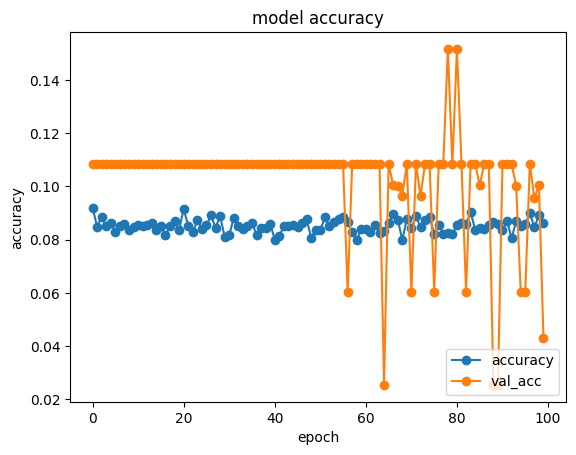

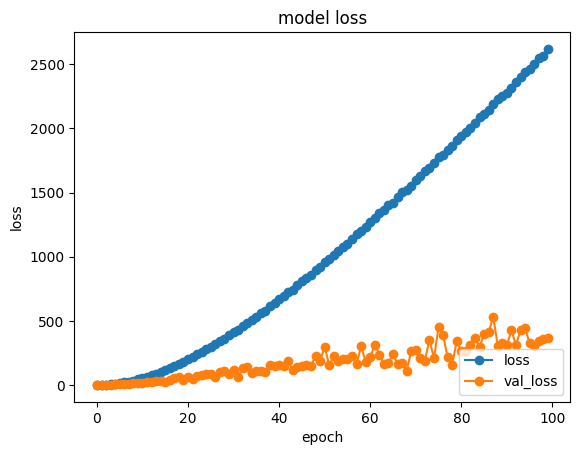

In [31]:
# loss 遷移のプロット

import matplotlib.pyplot as plt

plot_history(history)

In [33]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

model = load_model("../data/models/" + model_name)
file_name = "out_" + model_name

first_index = np.random.randint(0, len(x_test))
predict_index = first_index

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = -np.inf
    for cqt_chroma in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, cqt_chroma) 
        if tmp_sim > cos_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    
    if i == 0:
        out = clips[predict_index]
    else:
        out = np.hstack((out, clips[predict_index]))
    
sf.write("../data/out/" + file_name + "_1.wav", out, SAMPLING_RATE, subtype="PCM_16")

first_index = np.random.randint(0, len(x_test))
predict_index = first_index

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = -np.inf
    for cqt_chroma in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, cqt_chroma) 
        if tmp_sim > cos_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    
    if i == 0:
        out = clips[predict_index]
    else:
        out = np.hstack((out, clips[predict_index]))
    
sf.write("../data/out/" + file_name + "_2.wav", out, SAMPLING_RATE, subtype="PCM_16")

first_index = np.random.randint(0, len(x_test))
predict_index = first_index

for i in range(10):
    predict = model.predict(np.array([x_test[predict_index]]))
    
    index = 0
    similar_index = 0
    cos_sim = -np.inf
    for cqt_chroma in x_test[:, 0:1, :, 0]:
        tmp_sim = cosine_similarity(predict, cqt_chroma) 
        if tmp_sim > cos_sim:
            cos_sim = tmp_sim
            similar_index = index
        index += 1
    
    print(similar_index)
    
    predict_index = similar_index
    
    if i == 0:
        out = clips[predict_index]
    else:
        out = np.hstack((out, clips[predict_index]))
    
sf.write("../data/out/" + file_name + "_3.wav", out, SAMPLING_RATE, subtype="PCM_16")

1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [=======================